In [1]:
file_name = './DARNN_20211128_run/'

In [2]:
# 모듈 import
from datetime import datetime
import numpy as np
import os
import pandas as pd
import seaborn as sns

#from google.colab import drive
#drive.mount('/content/gdrive')
#os.chdir('/content/gdrive/MyDrive/python/python_dong/data_axis_transform1')

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

#!pip install torchmetrics
import torchmetrics

#!pip install torchinfo
from torchinfo import summary

import matplotlib.pyplot as plt
import math


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# data path 지정
raw_data_path = './data/stocknet-dataset/price/raw'

if 'stocknet' in raw_data_path:
    tra_date = '2014-01-02'
    val_date = '2015-08-03'
    tes_date = '2015-10-01'
    end_date = '2015-12-31'
elif 'kdd17' in raw_data_path:
    tra_date = '2007-01-03'
    val_date = '2015-01-02'
    tes_date = '2016-01-04'
    end_date = '2016-12-31'
else:
    print('unexpected path: %s' % raw_data_path)

# os.path.isfile : 파일이 있는지 없는 지 체크
# os.path.join(data_path, fname) : 폴더 디렉터리와 fname(stockname.csv) 붙임
fnames = [fname for fname in os.listdir(raw_data_path) if
            os.path.isfile(os.path.join(raw_data_path,fname))]

COLUMNS_FEATURE_DATA_V1 = ['open_close_ratio', 'high_close_ratio', 
                           'low_close_ratio', 'close_lastclose_ratio', 
                           'adjclose_lastadjclose_ratio', 'close_ma5_ratio', 
                           'close_ma10_ratio', 'close_ma15_ratio', 'close_ma20_ratio', 
                           'close_ma25_ratio', 'close_ma30_ratio']

ver = 'v1' # ver in ['v1', 'v2']
if ver == 'v1':
    COLUMNS_FEATURE = COLUMNS_FEATURE_DATA_V1

In [4]:
windows = [5,10,15,20,25,30]

def preprocess(df, windows):
   '''
   전처리 함수 역할 : 전체 feature생성하여 df column에 추가
   '''
   data = df
   data['open_close_ratio'] = data['Open'] / data['Close'] - 1
   data['high_close_ratio'] = data['High'] / data['Close'] - 1
   data['low_close_ratio'] = data['Low'] / data['Close'] - 1

   data['close_lastclose_ratio'] = np.zeros(len(data))
   data.loc[1:, 'close_lastclose_ratio'] = data['Close'][1:].values / data['Close'][:-1].values - 1

   data['adjclose_lastadjclose_ratio'] = np.zeros(len(data))
   data.loc[1:, 'adjclose_lastadjclose_ratio'] = data['Adj Close'][1:].values / data['Adj Close'][:-1].values - 1

   for window in windows:
      data[f'close_ma{window}_ratio'] = data['Adj Close'].rolling(window).mean()/data['Adj Close'] - 1
   
   data['label'] = np.append((data['Close'][1:].values > data['Close'][:-1].values)*1,0)

   return data

In [5]:
feature_data_path = './data/stocknet-dataset/price/feature'

for fname in fnames:
   if not os.path.isfile(os.path.join(feature_data_path,fname)):
      df_raw = pd.read_csv(os.path.join(raw_data_path,fname))
      data = preprocess(df_raw, windows)

      # 폴더 없으면 생성
      try:
         if not os.path.exists(feature_data_path):
            os.makedirs(feature_data_path)
      except OSError:
         print ('Error: Creating directory. ' +  feature_data_path)

      #csv 파일 저장
      data.to_csv(os.path.join(feature_data_path,fname))



In [6]:
raw_data_path = './data/stocknet-dataset/price/raw'


tra_data_X = []
tra_data_Y = []
val_data_X = []
val_data_Y = []
test_data_X = []
test_data_Y = []
tickers = []

cnt = 0
fail_cnt = 0

fnames = [fname for fname in os.listdir(raw_data_path) if
            os.path.isfile(os.path.join(raw_data_path,fname))]

for fname in fnames:

    df = pd.read_csv(os.path.join(raw_data_path,fname))
    data = preprocess(df, windows)

    learning_data = data[(data['Date'] >= tra_date) & (data['Date'] <= end_date)]['Date']
    tra_data_X_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)][COLUMNS_FEATURE]
    tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['adjclose_lastadjclose_ratio']
    #tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['label']

    val_data_X_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)][COLUMNS_FEATURE]
    val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['adjclose_lastadjclose_ratio']
    #val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['label'] 

    test_data_X_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)][COLUMNS_FEATURE]
    test_data_Y_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)]['adjclose_lastadjclose_ratio']
    #test_data_Y_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)]['label']


    if cnt == 0:
        # 첫 티커의 learining_data는 학습 date를 갖는 array
        # 첫 티커의 학습 date를 target_dates로 두고, 다음 티커들은 target_dates와 대조
        # 학습 date가 같으면 학습data에 추가, 아니면 추가하지않음
        # 학습 date가 같으면 vali, test date도 같은걸로 가정
        target_dates = learning_data
    
    print('ticker : {}, date check : {}'.format(fname, np.array_equal(target_dates.values, learning_data.values)))
    #print('X_null data count : train {}, val {}, test {}'
    #    .format(tra_data_X_ticker.head().isnull().sum().sum(), val_data_X_ticker.head().isnull().sum().sum(), test_data_X_ticker.head().isnull().sum().sum()))
    #print('y_null data count : train {}, val {}, test {}'
    #    .format(tra_data_Y_ticker.head().isnull().sum().sum(), val_data_Y_ticker.head().isnull().sum().sum(), test_data_Y_ticker.head().isnull().sum().sum()))
        
    if np.array_equal(target_dates.values, learning_data.values): 
        
        tra_data_X.append(tra_data_X_ticker.values)
        tra_data_Y.append(tra_data_Y_ticker.values)

        val_data_X.append(val_data_X_ticker.values)
        val_data_Y.append(val_data_Y_ticker.values)
        
        test_data_X.append(test_data_X_ticker.values)
        test_data_Y.append(test_data_Y_ticker.values)

        tickers.append(fname)
    else : 
        fail_cnt += 1
    
    cnt += 1

print(cnt, len(fnames))
print('fail_cnt :', fail_cnt)

'''
# 마지막에 index 종목 넣기
raw_data_index_path = './data/stocknet-dataset/price/raw/index'

fname = os.listdir(raw_data_index_path)[0]

df = pd.read_csv(os.path.join(raw_data_index_path,fname))
data = preprocess(df, windows)

learning_data = data[(data['Date'] >= tra_date) & (data['Date'] <= end_date)]['Date']
tra_data_X_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)][COLUMNS_FEATURE]
tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['adjclose_lastadjclose_ratio']
#tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['label']

val_data_X_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)][COLUMNS_FEATURE]
val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['adjclose_lastadjclose_ratio']
#val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['label']

test_data_X_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)][COLUMNS_FEATURE]
test_data_Y_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)]['adjclose_lastadjclose_ratio']
#test_data_Y_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)]['label']

print('ticker : {}, date check : {}'.format(fname, np.array_equal(target_dates.values, learning_data.values)))
if np.array_equal(target_dates.values, learning_data.values):
    
    tra_data_X.append(tra_data_X_ticker.values)
    # tra_data_Y.append(tra_data_Y_ticker.values)

    val_data_X.append(val_data_X_ticker.values)
    # val_data_Y.append(val_data_Y_ticker.values)
    
    test_data_X.append(test_data_X_ticker.values)
    # test_data_Y.append(test_data_Y_ticker.values)

    tickers.append(fname)

# tra_data_X
'''

ticker : AAPL.csv, date check : True
ticker : ABB.csv, date check : True
ticker : ABBV.csv, date check : True
ticker : AEP.csv, date check : True
ticker : AGFS.csv, date check : False
ticker : AMGN.csv, date check : True
ticker : AMZN.csv, date check : True
ticker : BA.csv, date check : True
ticker : BABA.csv, date check : False
ticker : BAC.csv, date check : True
ticker : BBL.csv, date check : True
ticker : BCH.csv, date check : True
ticker : BHP.csv, date check : True
ticker : BP.csv, date check : True
ticker : BRK-A.csv, date check : True
ticker : BSAC.csv, date check : True
ticker : BUD.csv, date check : True
ticker : C.csv, date check : True
ticker : CAT.csv, date check : True
ticker : CELG.csv, date check : True
ticker : CHL.csv, date check : True
ticker : CHTR.csv, date check : True
ticker : CMCSA.csv, date check : True
ticker : CODI.csv, date check : True
ticker : CSCO.csv, date check : True
ticker : CVX.csv, date check : True
ticker : D.csv, date check : True
ticker : DHR.csv,

"\n# 마지막에 index 종목 넣기\nraw_data_index_path = './data/stocknet-dataset/price/raw/index'\n\nfname = os.listdir(raw_data_index_path)[0]\n\ndf = pd.read_csv(os.path.join(raw_data_index_path,fname))\ndata = preprocess(df, windows)\n\nlearning_data = data[(data['Date'] >= tra_date) & (data['Date'] <= end_date)]['Date']\ntra_data_X_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)][COLUMNS_FEATURE]\ntra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['adjclose_lastadjclose_ratio']\n#tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['label']\n\nval_data_X_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)][COLUMNS_FEATURE]\nval_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['adjclose_lastadjclose_ratio']\n#val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['label']\n\ntest_data_X_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= 

In [7]:
def list_to_tensor(list_):
    return torch.Tensor(np.array(list_))

In [8]:
tensor_tra_data_X = list_to_tensor(tra_data_X)
tensor_tra_data_Y = list_to_tensor(tra_data_Y).view((len(tra_data_Y),-1,1))
tensor_val_data_X = list_to_tensor(val_data_X)
tensor_val_data_Y = list_to_tensor(val_data_Y).view((len(val_data_Y),-1,1))
tensor_test_data_X = list_to_tensor(test_data_X)
tensor_test_data_Y = list_to_tensor(test_data_Y).view((len(test_data_Y),-1,1))

In [9]:
from torch.autograd import Variable

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F


class Encoder(nn.Module):
    """encoder in DA_RNN."""

    def __init__(self, T,
                 input_size,
                 encoder_num_hidden,
                 parallel=False):
        """Initialize an encoder in DA_RNN."""
        super(Encoder, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.input_size = input_size
        self.parallel = parallel
        self.T = T

        # Fig 1. Temporal Attention Mechanism: Encoder is LSTM
        self.encoder_lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.encoder_num_hidden,
            num_layers = 1
        )

        # Construct Input Attention Mechanism via deterministic attention model
        # Eq. 8: W_e[h_{t-1}; s_{t-1}] + U_e * x^k
        self.encoder_attn = nn.Linear(
            in_features=2 * self.encoder_num_hidden + self.T - 1,
            out_features=1
        )

    def forward(self, X):
        """forward.

        Args:
            X: input data

        """
        X_tilde = Variable(X.data.new(
            X.size(0), self.T - 1, self.input_size).zero_())
        X_encoded = Variable(X.data.new(
            X.size(0), self.T - 1, self.encoder_num_hidden).zero_())

        # Eq. 8, parameters not in nn.Linear but to be learnt
        # v_e = torch.nn.Parameter(data=torch.empty(
        #     self.input_size, self.T).uniform_(0, 1), requires_grad=True)
        # U_e = torch.nn.Parameter(data=torch.empty(
        #     self.T, self.T).uniform_(0, 1), requires_grad=True)

        # h_n, s_n: initial states with dimention hidden_size
        h_n = self._init_states(X)
        s_n = self._init_states(X)

        for t in range(self.T - 1):
            # batch_size * input_size * (2 * hidden_size + T - 1)
            x = torch.cat((h_n.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           s_n.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           X.permute(0, 2, 1)), dim=2)

            x = self.encoder_attn(
                x.view(-1, self.encoder_num_hidden * 2 + self.T - 1))

            # get weights by softmax
            alpha = F.softmax(x.view(-1, self.input_size), dim=1)

            # get new input for LSTM
            x_tilde = torch.mul(alpha, X[:, t, :])

            # Fix the warning about non-contiguous memory
            # https://discuss.pytorch.org/t/dataparallel-issue-with-flatten-parameter/8282
            self.encoder_lstm.flatten_parameters()

            # encoder LSTM
            _, final_state = self.encoder_lstm(x_tilde.unsqueeze(0), (h_n, s_n))
            h_n = final_state[0]
            s_n = final_state[1]

            X_tilde[:, t, :] = x_tilde
            X_encoded[:, t, :] = h_n

        return X_tilde, X_encoded

    def _init_states(self, X):
        """Initialize all 0 hidden states and cell states for encoder.

        Args:
            X

        Returns:
            initial_hidden_states
        """
        # https://pytorch.org/docs/master/nn.html?#lstm
        return Variable(X.data.new(1, X.size(0), self.encoder_num_hidden).zero_())


class Decoder(nn.Module):
    """decoder in DA_RNN."""

    def __init__(self, T, decoder_num_hidden, encoder_num_hidden):
        """Initialize a decoder in DA_RNN."""
        super(Decoder, self).__init__()
        self.decoder_num_hidden = decoder_num_hidden
        self.encoder_num_hidden = encoder_num_hidden
        self.T = T

        self.attn_layer = nn.Sequential(
            nn.Linear(2 * decoder_num_hidden + encoder_num_hidden, encoder_num_hidden),
            nn.Tanh(),
            nn.Linear(encoder_num_hidden, 1)
        )
        self.lstm_layer = nn.LSTM(
            input_size=1,
            hidden_size=decoder_num_hidden
        )
        self.fc = nn.Linear(encoder_num_hidden + 1, 1)
        self.fc_final = nn.Linear(decoder_num_hidden + encoder_num_hidden, 1)

        self.fc.weight.data.normal_()

    def forward(self, X_encoded, y_prev):
        """forward."""
        d_n = self._init_states(X_encoded)
        c_n = self._init_states(X_encoded)

        for t in range(self.T - 1):

            x = torch.cat((d_n.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           c_n.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           X_encoded), dim=2)

            beta = F.softmax(self.attn_layer(
                x.view(-1, 2 * self.decoder_num_hidden + self.encoder_num_hidden)).view(-1, self.T - 1), dim=1)

            # Eqn. 14: compute context vector
            # batch_size * encoder_hidden_size
            context = torch.bmm(beta.unsqueeze(1), X_encoded)[:, 0, :]
            if t < self.T - 1:
                # Eqn. 15
                # batch_size * 1
                y_tilde = self.fc(
                    torch.cat((context, y_prev[:, t].unsqueeze(1)), dim=1))

                # Eqn. 16: LSTM
                self.lstm_layer.flatten_parameters()
                _, final_states = self.lstm_layer(
                    y_tilde.unsqueeze(0), (d_n, c_n))

                d_n = final_states[0]  # 1 * batch_size * decoder_num_hidden
                c_n = final_states[1]  # 1 * batch_size * decoder_num_hidden

        # Eqn. 22: final output
        y_pred = self.fc_final(torch.cat((d_n[0], context), dim=1))

        return y_pred

    def _init_states(self, X):
        """Initialize all 0 hidden states and cell states for encoder.

        Args:
            X
        Returns:
            initial_hidden_states

        """
        # hidden state and cell state [num_layers*num_directions, batch_size, hidden_size]
        # https://pytorch.org/docs/master/nn.html?#lstm
        return Variable(X.data.new(1, X.size(0), self.decoder_num_hidden).zero_())


class DA_rnn(nn.Module):
    """da_rnn."""

    def __init__(self, X, y, T,
                 encoder_num_hidden,
                 decoder_num_hidden,
                 batch_size,
                 learning_rate,
                 epochs,
                 parallel=False):
        """da_rnn initialization."""
        super(DA_rnn, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.decoder_num_hidden = decoder_num_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.parallel = parallel
        self.shuffle = False
        self.epochs = epochs
        self.T = T
        self.X = X
        self.y = y

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print("==> Use accelerator: ", self.device)

        self.Encoder = Encoder(input_size=X.shape[1],
                               encoder_num_hidden=encoder_num_hidden,
                               T=T).to(self.device)
        self.Decoder = Decoder(encoder_num_hidden=encoder_num_hidden,
                               decoder_num_hidden=decoder_num_hidden,
                               T=T).to(self.device)

        # Loss function
        self.criterion = nn.MSELoss()

        if self.parallel:
            self.encoder = nn.DataParallel(self.encoder)
            self.decoder = nn.DataParallel(self.decoder)

        self.encoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad,
                                                          self.Encoder.parameters()),
                                            lr=self.learning_rate)
        self.decoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad,
                                                          self.Decoder.parameters()),
                                            lr=self.learning_rate)

        # Training set
        self.train_timesteps = int(self.X.shape[0] * 0.7)
        self.y = self.y - np.mean(self.y[:self.train_timesteps])
        self.input_size = self.X.shape[1]

    def train(self):
        """training process."""
        iter_per_epoch = int(np.ceil(self.train_timesteps * 1. / self.batch_size))
        self.iter_losses = np.zeros(self.epochs * iter_per_epoch)
        self.epoch_losses = np.zeros(self.epochs)

        n_iter = 0

        for epoch in range(self.epochs):
            if self.shuffle:
                ref_idx = np.random.permutation(self.train_timesteps - self.T)
            else:
                ref_idx = np.array(range(self.train_timesteps - self.T))

            idx = 0

            while (idx < self.train_timesteps):
                # get the indices of X_train
                indices = ref_idx[idx:(idx + self.batch_size)]
                # x = np.zeros((self.T - 1, len(indices), self.input_size))
                x = np.zeros((len(indices), self.T - 1, self.input_size))
                y_prev = np.zeros((len(indices), self.T - 1))
                y_gt = self.y[indices + self.T]

                # format x into 3D tensor
                for bs in range(len(indices)):
                    x[bs, :, :] = self.X[indices[bs]:(indices[bs] + self.T - 1), :]
                    y_prev[bs, :] = self.y[indices[bs]: (indices[bs] + self.T - 1)]

                loss = self.train_forward(x, y_prev, y_gt)
                self.iter_losses[int(epoch * iter_per_epoch + idx / self.batch_size)] = loss

                idx += self.batch_size
                n_iter += 1

                if n_iter % 10000 == 0 and n_iter != 0:
                    for param_group in self.encoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                    for param_group in self.decoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9

                self.epoch_losses[epoch] = np.mean(self.iter_losses[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])

            if epoch % 500 == 0:
                print("Epochs: ", epoch, " Iterations: ", n_iter,
                      " Loss: ", self.epoch_losses[epoch])

            if epoch % 10000 == 0:
                y_train_pred = self.test(on_train=True)
                y_test_pred = self.test(on_train=False)
                y_pred = np.concatenate((y_train_pred, y_test_pred))
                plt.ioff()
                plt.figure()
                plt.plot(range(1, 1 + len(self.y)), self.y, label="True")
                plt.plot(range(self.T, len(y_train_pred) + self.T),
                         y_train_pred, label='Predicted - Train')
                plt.plot(range(self.T + len(y_train_pred), len(self.y) + 1),
                         y_test_pred, label='Predicted - Test')
                plt.legend(loc='upper left')
                plt.show()

            # # Save files in last iterations
            # if epoch == self.epochs - 1:
            #     np.savetxt('../loss.txt', np.array(self.epoch_losses), delimiter=',')
            #     np.savetxt('../y_pred.txt',
            #                np.array(self.y_pred), delimiter=',')
            #     np.savetxt('../y_true.txt',
            #                np.array(self.y_true), delimiter=',')

    def train_forward(self, X, y_prev, y_gt):
        """
        Forward pass.

        Args:
            X:
            y_prev:
            y_gt: Ground truth label

        """
        # zero gradients
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        input_weighted, input_encoded = self.Encoder(
            Variable(torch.from_numpy(X).type(torch.FloatTensor).to(self.device)))
        y_pred = self.Decoder(input_encoded, Variable(
            torch.from_numpy(y_prev).type(torch.FloatTensor).to(self.device)))

        y_true = Variable(torch.from_numpy(
            y_gt).type(torch.FloatTensor).to(self.device))

        y_true = y_true.view(-1, 1)
        loss = self.criterion(y_pred, y_true)
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return loss.item()


    def test(self, on_train=False):
        """test."""

        if on_train:
            y_pred = np.zeros(self.train_timesteps - self.T + 1)
        else:
            y_pred = np.zeros(self.X.shape[0] - self.train_timesteps)

        i = 0
        while i < len(y_pred):
            batch_idx = np.array(range(len(y_pred)))[i: (i + self.batch_size)]
            X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
            y_history = np.zeros((len(batch_idx), self.T - 1))

            for j in range(len(batch_idx)):
                if on_train:
                    X[j, :, :] = self.X[range(
                        batch_idx[j], batch_idx[j] + self.T - 1), :]
                    y_history[j, :] = self.y[range(
                        batch_idx[j], batch_idx[j] + self.T - 1)]
                else:
                    X[j, :, :] = self.X[range(
                        batch_idx[j] + self.train_timesteps - self.T, batch_idx[j] + self.train_timesteps - 1), :]
                    y_history[j, :] = self.y[range(
                        batch_idx[j] + self.train_timesteps - self.T, batch_idx[j] + self.train_timesteps - 1)]

            y_history = Variable(torch.from_numpy(
                y_history).type(torch.FloatTensor).to(self.device))
            _, input_encoded = self.Encoder(
                Variable(torch.from_numpy(X).type(torch.FloatTensor).to(self.device)))
            y_pred[i:(i + self.batch_size)] = self.Decoder(input_encoded,
                                                           y_history).cpu().data.numpy()[:, 0]
            i += self.batch_size

        return y_pred

==> Initialize DA-RNN_0 model ...
==> Use accelerator:  cpu
==> Start training ...
Epochs:  0  Iterations:  3  Loss:  0.000714848375840423


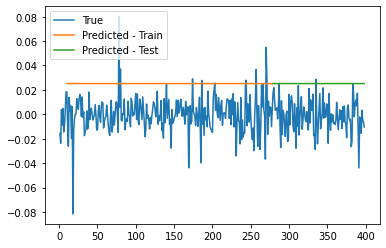

Epochs:  500  Iterations:  1503  Loss:  0.0002427739188230286
Epochs:  1000  Iterations:  3003  Loss:  0.00014794385060667992
Epochs:  1500  Iterations:  4503  Loss:  0.00012794039927636428
Epochs:  2000  Iterations:  6003  Loss:  0.00011335079625496292
Epochs:  2500  Iterations:  7503  Loss:  0.00011450820981432723
Epochs:  3000  Iterations:  9003  Loss:  0.0001197729590482292
Epochs:  3500  Iterations:  10503  Loss:  8.753346810408402e-05
Epochs:  4000  Iterations:  12003  Loss:  2.8349037317335995e-05
Epochs:  4500  Iterations:  13503  Loss:  3.605815739623116e-05
Epochs:  5000  Iterations:  15003  Loss:  9.270843673903073e-05
Epochs:  5500  Iterations:  16503  Loss:  3.9576837025379064e-05
Epochs:  6000  Iterations:  18003  Loss:  3.0892649457806933e-06
Epochs:  6500  Iterations:  19503  Loss:  7.854823555438392e-06
Epochs:  7000  Iterations:  21003  Loss:  7.270229464969209e-06
Epochs:  7500  Iterations:  22503  Loss:  5.996406950240877e-07
Epochs:  8000  Iterations:  24003  Loss:

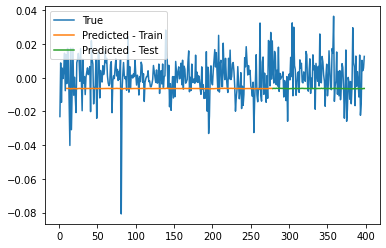

Epochs:  500  Iterations:  1503  Loss:  0.00013520727710177502
Epochs:  1000  Iterations:  3003  Loss:  0.00012828561739297584
Epochs:  1500  Iterations:  4503  Loss:  0.00012399514525895938
Epochs:  2000  Iterations:  6003  Loss:  0.00012779962708009407
Epochs:  2500  Iterations:  7503  Loss:  0.00010531046670318271
Epochs:  3000  Iterations:  9003  Loss:  9.734652424716235e-05
Epochs:  3500  Iterations:  10503  Loss:  0.00010378652829482841
Epochs:  4000  Iterations:  12003  Loss:  8.157804685045751e-05
Epochs:  4500  Iterations:  13503  Loss:  8.488583383344424e-05
Epochs:  5000  Iterations:  15003  Loss:  0.0001380048100448524
Epochs:  5500  Iterations:  16503  Loss:  7.034425834717695e-05
Epochs:  6000  Iterations:  18003  Loss:  6.836078561415586e-05
Epochs:  6500  Iterations:  19503  Loss:  4.929746349565297e-05
Epochs:  7000  Iterations:  21003  Loss:  1.898521346295941e-05
Epochs:  7500  Iterations:  22503  Loss:  8.47438650453114e-06
Epochs:  8000  Iterations:  24003  Loss:  

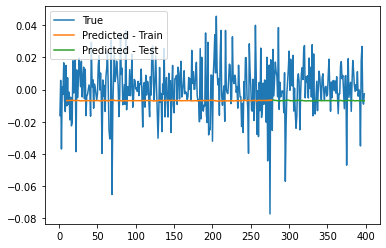

Epochs:  500  Iterations:  1503  Loss:  0.00021878036932321265
Epochs:  1000  Iterations:  3003  Loss:  0.00023889944714028388
Epochs:  1500  Iterations:  4503  Loss:  0.00020580305863404647
Epochs:  2000  Iterations:  6003  Loss:  0.00018390120203548577
Epochs:  2500  Iterations:  7503  Loss:  0.0001621682316302516
Epochs:  3000  Iterations:  9003  Loss:  0.0001533250509358671
Epochs:  3500  Iterations:  10503  Loss:  0.0001271256043461714
Epochs:  4000  Iterations:  12003  Loss:  0.00010203490417855694
Epochs:  4500  Iterations:  13503  Loss:  6.28596602230876e-05
Epochs:  5000  Iterations:  15003  Loss:  2.6124239970689207e-05
Epochs:  5500  Iterations:  16503  Loss:  2.910715753993524e-05
Epochs:  6000  Iterations:  18003  Loss:  7.73788368254221e-06
Epochs:  6500  Iterations:  19503  Loss:  2.707324052645769e-06
Epochs:  7000  Iterations:  21003  Loss:  2.330809567944551e-07
Epochs:  7500  Iterations:  22503  Loss:  2.4868152574223736e-06
Epochs:  8000  Iterations:  24003  Loss:  

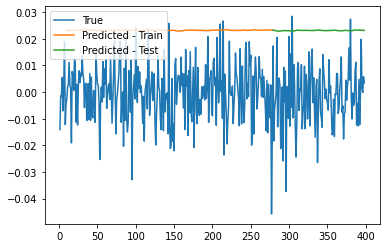

Epochs:  500  Iterations:  1503  Loss:  0.0001449958338829068
Epochs:  1000  Iterations:  3003  Loss:  0.00013129964888018245
Epochs:  1500  Iterations:  4503  Loss:  0.00011935190802129607
Epochs:  2000  Iterations:  6003  Loss:  0.0001383844210067764
Epochs:  2500  Iterations:  7503  Loss:  0.00011360209949392204
Epochs:  3000  Iterations:  9003  Loss:  0.00011533251866543044
Epochs:  3500  Iterations:  10503  Loss:  0.00011841060525815313
Epochs:  4000  Iterations:  12003  Loss:  0.00011187432998364481
Epochs:  4500  Iterations:  13503  Loss:  6.0034181236308846e-05
Epochs:  5000  Iterations:  15003  Loss:  6.424721141229384e-05
Epochs:  5500  Iterations:  16503  Loss:  4.438709629539517e-05
Epochs:  6000  Iterations:  18003  Loss:  3.585666763683548e-05
Epochs:  6500  Iterations:  19503  Loss:  5.02875241181755e-05
Epochs:  7000  Iterations:  21003  Loss:  3.865957144929174e-05
Epochs:  7500  Iterations:  22503  Loss:  0.00013576184816580886
Epochs:  8000  Iterations:  24003  Loss:

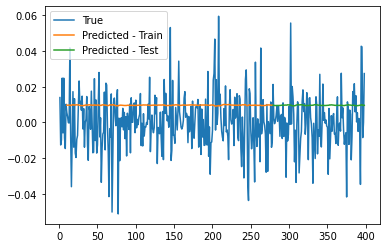

Epochs:  500  Iterations:  1503  Loss:  0.00020756507001351565
Epochs:  1000  Iterations:  3003  Loss:  0.0001866834184814555
Epochs:  1500  Iterations:  4503  Loss:  0.0001883068277190129
Epochs:  2000  Iterations:  6003  Loss:  0.00018725544820578458
Epochs:  2500  Iterations:  7503  Loss:  0.0001882773346248238
Epochs:  3000  Iterations:  9003  Loss:  0.0001852141152388261
Epochs:  3500  Iterations:  10503  Loss:  0.0001754299458601357
Epochs:  4000  Iterations:  12003  Loss:  0.0001685877396084834
Epochs:  4500  Iterations:  13503  Loss:  0.00017502280146194002
Epochs:  5000  Iterations:  15003  Loss:  0.0001741387544219227
Epochs:  5500  Iterations:  16503  Loss:  0.00013865916086312305
Epochs:  6000  Iterations:  18003  Loss:  7.3435181396538e-05
Epochs:  6500  Iterations:  19503  Loss:  1.8971405855457608e-05
Epochs:  7000  Iterations:  21003  Loss:  2.089635624239842e-06
Epochs:  7500  Iterations:  22503  Loss:  1.911246878686749e-06
Epochs:  8000  Iterations:  24003  Loss:  2.

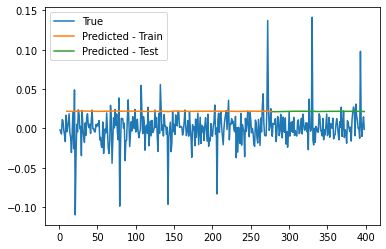

Epochs:  500  Iterations:  1503  Loss:  0.0005286797919931511
Epochs:  1000  Iterations:  3003  Loss:  0.000276185064042996
Epochs:  1500  Iterations:  4503  Loss:  0.0002460637776190803
Epochs:  2000  Iterations:  6003  Loss:  0.0002384860951375837
Epochs:  2500  Iterations:  7503  Loss:  0.0001983633060262946
Epochs:  3000  Iterations:  9003  Loss:  0.0003902799653587863
Epochs:  3500  Iterations:  10503  Loss:  0.00021928537777663829
Epochs:  4000  Iterations:  12003  Loss:  0.00048199262043150765
Epochs:  4500  Iterations:  13503  Loss:  0.00020405571012815926
Epochs:  5000  Iterations:  15003  Loss:  0.0004831923336799567
Epochs:  5500  Iterations:  16503  Loss:  0.0006558097472103933
Epochs:  6000  Iterations:  18003  Loss:  0.00035938399863274145
Epochs:  6500  Iterations:  19503  Loss:  0.0002577993048665424
Epochs:  7000  Iterations:  21003  Loss:  0.00027684531111541827
Epochs:  7500  Iterations:  22503  Loss:  0.00031974548134409514
Epochs:  8000  Iterations:  24003  Loss:  

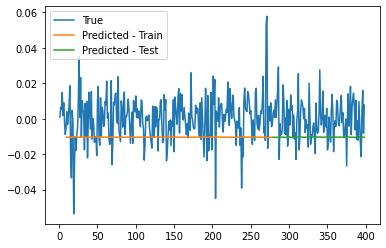

Epochs:  500  Iterations:  1503  Loss:  0.00026463126414455473
Epochs:  1000  Iterations:  3003  Loss:  0.00024602143093943596
Epochs:  1500  Iterations:  4503  Loss:  0.00016339591820724308
Epochs:  2000  Iterations:  6003  Loss:  0.0001551227226930981
Epochs:  2500  Iterations:  7503  Loss:  0.00018053561022194722
Epochs:  3000  Iterations:  9003  Loss:  0.0002055561296098555
Epochs:  3500  Iterations:  10503  Loss:  0.00019556017165693143
Epochs:  4000  Iterations:  12003  Loss:  0.0001947612278551484
Epochs:  4500  Iterations:  13503  Loss:  0.0001871222339104861
Epochs:  5000  Iterations:  15003  Loss:  0.00018940070003736764
Epochs:  5500  Iterations:  16503  Loss:  0.0001942778326338157
Epochs:  6000  Iterations:  18003  Loss:  0.00018814978830050677
Epochs:  6500  Iterations:  19503  Loss:  0.00017951147553200522
Epochs:  7000  Iterations:  21003  Loss:  0.00018343746584529677
Epochs:  7500  Iterations:  22503  Loss:  0.0001480010420588466
Epochs:  8000  Iterations:  24003  Los

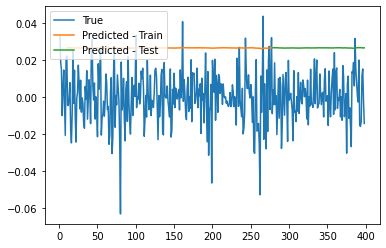

Epochs:  500  Iterations:  1503  Loss:  0.0002358476291798676
Epochs:  1000  Iterations:  3003  Loss:  0.00016719963362750909
Epochs:  1500  Iterations:  4503  Loss:  0.00015264769172063097
Epochs:  2000  Iterations:  6003  Loss:  0.00015779814323953664
Epochs:  2500  Iterations:  7503  Loss:  0.00012717917873790915
Epochs:  3000  Iterations:  9003  Loss:  0.00012115126234372535
Epochs:  3500  Iterations:  10503  Loss:  0.0001536965149474175
Epochs:  4000  Iterations:  12003  Loss:  0.0001193563415048023
Epochs:  4500  Iterations:  13503  Loss:  0.00013029362071392825
Epochs:  5000  Iterations:  15003  Loss:  0.00010979859204477786
Epochs:  5500  Iterations:  16503  Loss:  9.657850318944838e-05
Epochs:  6000  Iterations:  18003  Loss:  8.574190390694032e-05
Epochs:  6500  Iterations:  19503  Loss:  4.6120241563585296e-05
Epochs:  7000  Iterations:  21003  Loss:  2.5420118807536102e-05
Epochs:  7500  Iterations:  22503  Loss:  0.00019251873042473258
Epochs:  8000  Iterations:  24003  Lo

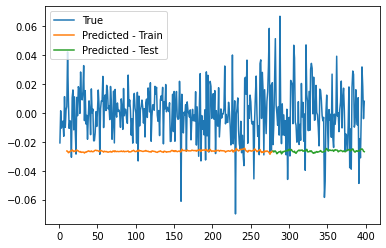

Epochs:  500  Iterations:  1503  Loss:  0.0003458402691952263
Epochs:  1000  Iterations:  3003  Loss:  0.00035772011809361476
Epochs:  1500  Iterations:  4503  Loss:  0.000379788049031049
Epochs:  2000  Iterations:  6003  Loss:  0.00033369913580827415
Epochs:  2500  Iterations:  7503  Loss:  0.00032433321272643906
Epochs:  3000  Iterations:  9003  Loss:  0.00036880801781080663
Epochs:  3500  Iterations:  10503  Loss:  0.00030972435100314516
Epochs:  4000  Iterations:  12003  Loss:  0.00029290313735449064
Epochs:  4500  Iterations:  13503  Loss:  0.0004844563566924383
Epochs:  5000  Iterations:  15003  Loss:  0.0001797487699756554
Epochs:  5500  Iterations:  16503  Loss:  0.00018603337836490633
Epochs:  6000  Iterations:  18003  Loss:  0.00013817300346848546
Epochs:  6500  Iterations:  19503  Loss:  0.00012732408079803767
Epochs:  7000  Iterations:  21003  Loss:  0.00017701785084985508
Epochs:  7500  Iterations:  22503  Loss:  0.0001102223284306092
Epochs:  8000  Iterations:  24003  Los

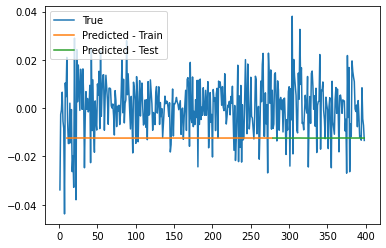

Epochs:  500  Iterations:  1503  Loss:  0.00013077049273609495
Epochs:  1000  Iterations:  3003  Loss:  0.00012391443548646444
Epochs:  1500  Iterations:  4503  Loss:  0.00011763251677621156
Epochs:  2000  Iterations:  6003  Loss:  0.00010963519404564674
Epochs:  2500  Iterations:  7503  Loss:  9.137762511575905e-05
Epochs:  3000  Iterations:  9003  Loss:  8.028298664915685e-05
Epochs:  3500  Iterations:  10503  Loss:  0.00012592310182905445
Epochs:  4000  Iterations:  12003  Loss:  0.00011998529953416437
Epochs:  4500  Iterations:  13503  Loss:  0.00010927502444246784
Epochs:  5000  Iterations:  15003  Loss:  0.00010118318217185636
Epochs:  5500  Iterations:  16503  Loss:  9.151643340980324e-05
Epochs:  6000  Iterations:  18003  Loss:  8.963110788802926e-05
Epochs:  6500  Iterations:  19503  Loss:  8.445326602668501e-05
Epochs:  7000  Iterations:  21003  Loss:  0.00012200939333221565
Epochs:  7500  Iterations:  22503  Loss:  0.00011689042003126815
Epochs:  8000  Iterations:  24003  Lo

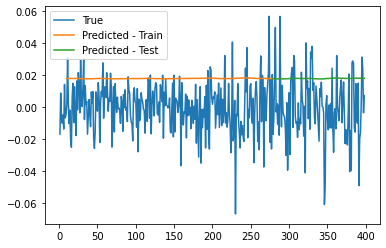

Epochs:  500  Iterations:  1503  Loss:  0.00029832631601796794
Epochs:  1000  Iterations:  3003  Loss:  0.0002427686364778007
Epochs:  1500  Iterations:  4503  Loss:  0.00019628235895652324
Epochs:  2000  Iterations:  6003  Loss:  0.00013079079811480673
Epochs:  2500  Iterations:  7503  Loss:  0.0001584845109997938
Epochs:  3000  Iterations:  9003  Loss:  7.181434375524987e-05
Epochs:  3500  Iterations:  10503  Loss:  5.351609130836247e-05
Epochs:  4000  Iterations:  12003  Loss:  2.5639480099926004e-05
Epochs:  4500  Iterations:  13503  Loss:  5.635757058068218e-06
Epochs:  5000  Iterations:  15003  Loss:  4.29891891447672e-06
Epochs:  5500  Iterations:  16503  Loss:  3.8075688735261792e-06
Epochs:  6000  Iterations:  18003  Loss:  1.3431501732460068e-05
Epochs:  6500  Iterations:  19503  Loss:  1.7517776124501931e-06
Epochs:  7000  Iterations:  21003  Loss:  9.10379443060568e-06
Epochs:  7500  Iterations:  22503  Loss:  2.4811617246693157e-05
Epochs:  8000  Iterations:  24003  Loss: 

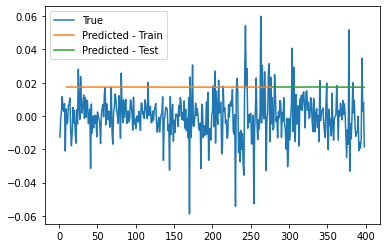

Epochs:  500  Iterations:  1503  Loss:  0.0002326957619516179
Epochs:  1000  Iterations:  3003  Loss:  0.00021373652998590842
Epochs:  1500  Iterations:  4503  Loss:  0.0002147738899414738
Epochs:  2000  Iterations:  6003  Loss:  0.00017155767030393085
Epochs:  2500  Iterations:  7503  Loss:  0.000160900085271957
Epochs:  3000  Iterations:  9003  Loss:  0.0001398815372037158
Epochs:  3500  Iterations:  10503  Loss:  0.00011030472008618138
Epochs:  4000  Iterations:  12003  Loss:  9.631020194926047e-05
Epochs:  4500  Iterations:  13503  Loss:  9.795802725420799e-05
Epochs:  5000  Iterations:  15003  Loss:  8.920072673390678e-05
Epochs:  5500  Iterations:  16503  Loss:  0.0002529164097116639
Epochs:  6000  Iterations:  18003  Loss:  9.944253785458083e-05
Epochs:  6500  Iterations:  19503  Loss:  9.365799208656729e-05
Epochs:  7000  Iterations:  21003  Loss:  7.649767561209349e-05
Epochs:  7500  Iterations:  22503  Loss:  8.417903882218525e-05
Epochs:  8000  Iterations:  24003  Loss:  0.0

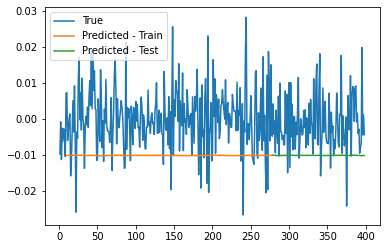

Epochs:  500  Iterations:  1503  Loss:  9.680155684084941e-05
Epochs:  1000  Iterations:  3003  Loss:  7.871778022187452e-05
Epochs:  1500  Iterations:  4503  Loss:  7.119607471395284e-05
Epochs:  2000  Iterations:  6003  Loss:  6.386096962766412e-05
Epochs:  2500  Iterations:  7503  Loss:  4.400381650763544e-05
Epochs:  3000  Iterations:  9003  Loss:  6.435839653325577e-05
Epochs:  3500  Iterations:  10503  Loss:  3.625088932797856e-05
Epochs:  4000  Iterations:  12003  Loss:  2.2406598342665045e-05
Epochs:  4500  Iterations:  13503  Loss:  1.8013246214347117e-05
Epochs:  5000  Iterations:  15003  Loss:  8.798162108784405e-06
Epochs:  5500  Iterations:  16503  Loss:  1.1014849311171322e-06
Epochs:  6000  Iterations:  18003  Loss:  6.992712068646748e-07
Epochs:  6500  Iterations:  19503  Loss:  3.218442619375613e-05
Epochs:  7000  Iterations:  21003  Loss:  9.715619777731868e-06
Epochs:  7500  Iterations:  22503  Loss:  1.939223049400122e-06
Epochs:  8000  Iterations:  24003  Loss:  1.

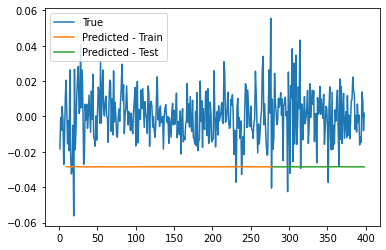

Epochs:  500  Iterations:  1503  Loss:  0.00024256761147019765
Epochs:  1000  Iterations:  3003  Loss:  0.0002583817986305803
Epochs:  1500  Iterations:  4503  Loss:  0.0002317934122402221
Epochs:  2000  Iterations:  6003  Loss:  0.0001837529222636173
Epochs:  2500  Iterations:  7503  Loss:  0.0001567739357900185
Epochs:  3000  Iterations:  9003  Loss:  0.00021214868562916914
Epochs:  3500  Iterations:  10503  Loss:  9.329973560549358e-05
Epochs:  4000  Iterations:  12003  Loss:  8.149403674906353e-05
Epochs:  4500  Iterations:  13503  Loss:  8.614230076394354e-05
Epochs:  5000  Iterations:  15003  Loss:  3.965966489734759e-05
Epochs:  5500  Iterations:  16503  Loss:  5.990686380149176e-05
Epochs:  6000  Iterations:  18003  Loss:  9.89119208346286e-06
Epochs:  6500  Iterations:  19503  Loss:  3.5808329812425654e-05
Epochs:  7000  Iterations:  21003  Loss:  1.5264104789025623e-06
Epochs:  7500  Iterations:  22503  Loss:  9.754767837932832e-07
Epochs:  8000  Iterations:  24003  Loss:  3.

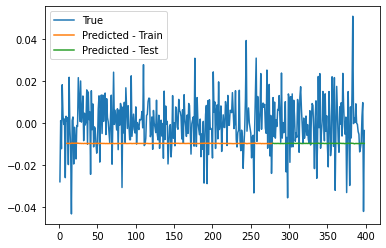

Epochs:  500  Iterations:  1503  Loss:  0.0001347891811747104
Epochs:  1000  Iterations:  3003  Loss:  0.00013168974207170928
Epochs:  1500  Iterations:  4503  Loss:  0.0001170385973334002
Epochs:  2000  Iterations:  6003  Loss:  0.00010927741095656529
Epochs:  2500  Iterations:  7503  Loss:  7.909781925263815e-05
Epochs:  3000  Iterations:  9003  Loss:  7.692000212955463e-05
Epochs:  3500  Iterations:  10503  Loss:  6.248106664467438e-05
Epochs:  4000  Iterations:  12003  Loss:  4.38468674322697e-05
Epochs:  4500  Iterations:  13503  Loss:  5.278919669156797e-05
Epochs:  5000  Iterations:  15003  Loss:  2.8931126128857915e-05
Epochs:  5500  Iterations:  16503  Loss:  7.86971581353176e-06
Epochs:  6000  Iterations:  18003  Loss:  5.019267379206364e-06
Epochs:  6500  Iterations:  19503  Loss:  1.620143219345967e-05
Epochs:  7000  Iterations:  21003  Loss:  2.786991368945261e-06
Epochs:  7500  Iterations:  22503  Loss:  1.3302643952310216e-06
Epochs:  8000  Iterations:  24003  Loss:  1.7

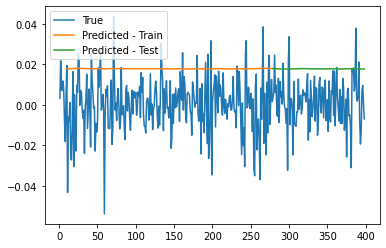

Epochs:  500  Iterations:  1503  Loss:  0.00018796878672825793
Epochs:  1000  Iterations:  3003  Loss:  0.00014778433614992537
Epochs:  1500  Iterations:  4503  Loss:  0.00013174470283653741
Epochs:  2000  Iterations:  6003  Loss:  0.00013322557909608199
Epochs:  2500  Iterations:  7503  Loss:  0.0001980852442405497
Epochs:  3000  Iterations:  9003  Loss:  0.00011865025620257559
Epochs:  3500  Iterations:  10503  Loss:  0.00011508760780998273
Epochs:  4000  Iterations:  12003  Loss:  0.000107191455716323
Epochs:  4500  Iterations:  13503  Loss:  0.00010356033180869417
Epochs:  5000  Iterations:  15003  Loss:  8.272446461887739e-05
Epochs:  5500  Iterations:  16503  Loss:  8.108841734610905e-05
Epochs:  6000  Iterations:  18003  Loss:  0.00010009939069277607
Epochs:  6500  Iterations:  19503  Loss:  9.513941010178921e-05
Epochs:  7000  Iterations:  21003  Loss:  6.681243451112095e-05
Epochs:  7500  Iterations:  22503  Loss:  6.813094523749896e-05
Epochs:  8000  Iterations:  24003  Loss:

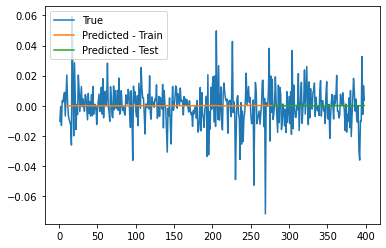

Epochs:  500  Iterations:  1503  Loss:  0.00032395058951806277
Epochs:  1000  Iterations:  3003  Loss:  0.0002652677018583442
Epochs:  1500  Iterations:  4503  Loss:  0.0003088122175540775
Epochs:  2000  Iterations:  6003  Loss:  0.00032703307806514204
Epochs:  2500  Iterations:  7503  Loss:  0.00025883502773164463
Epochs:  3000  Iterations:  9003  Loss:  0.00023247829327980676
Epochs:  3500  Iterations:  10503  Loss:  0.0001984709573055928
Epochs:  4000  Iterations:  12003  Loss:  0.00028726461944946397
Epochs:  4500  Iterations:  13503  Loss:  0.00017009269261810309
Epochs:  5000  Iterations:  15003  Loss:  0.00011928806634387001
Epochs:  5500  Iterations:  16503  Loss:  9.845132035479764e-05
Epochs:  6000  Iterations:  18003  Loss:  0.00010126824842397279
Epochs:  6500  Iterations:  19503  Loss:  9.157602668589486e-05
Epochs:  7000  Iterations:  21003  Loss:  8.70763049836872e-05
Epochs:  7500  Iterations:  22503  Loss:  8.064550362026542e-05
Epochs:  8000  Iterations:  24003  Loss:

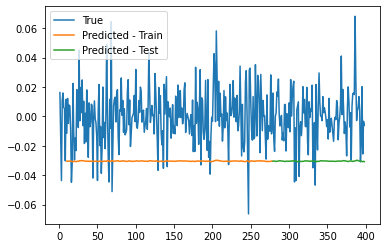

Epochs:  500  Iterations:  1503  Loss:  0.00030401199182961136
Epochs:  1000  Iterations:  3003  Loss:  0.0002485019128168157
Epochs:  1500  Iterations:  4503  Loss:  0.00020495259832387092
Epochs:  2000  Iterations:  6003  Loss:  0.00015442520543729188
Epochs:  2500  Iterations:  7503  Loss:  5.442175127730783e-05
Epochs:  3000  Iterations:  9003  Loss:  1.580888389677663e-05
Epochs:  3500  Iterations:  10503  Loss:  2.819272234925544e-06
Epochs:  4000  Iterations:  12003  Loss:  4.031990859706032e-06
Epochs:  4500  Iterations:  13503  Loss:  2.5696656772803785e-06
Epochs:  5000  Iterations:  15003  Loss:  7.353259813195716e-05
Epochs:  5500  Iterations:  16503  Loss:  1.3497639486104163e-06
Epochs:  6000  Iterations:  18003  Loss:  1.5787083418317138e-08
Epochs:  6500  Iterations:  19503  Loss:  1.9735089858604247e-09
Epochs:  7000  Iterations:  21003  Loss:  7.173429897496438e-07
Epochs:  7500  Iterations:  22503  Loss:  1.7507580688895057e-06
Epochs:  8000  Iterations:  24003  Loss

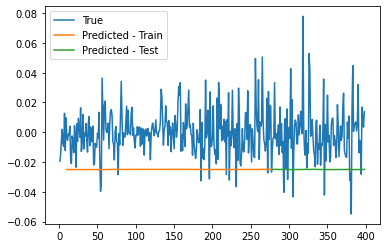

Epochs:  500  Iterations:  1503  Loss:  0.00022020611019494632
Epochs:  1000  Iterations:  3003  Loss:  0.00020252951556661478
Epochs:  1500  Iterations:  4503  Loss:  0.0001840187445244131
Epochs:  2000  Iterations:  6003  Loss:  0.00013752341146755498
Epochs:  2500  Iterations:  7503  Loss:  0.00011069905849581119
Epochs:  3000  Iterations:  9003  Loss:  0.00010093778337250114
Epochs:  3500  Iterations:  10503  Loss:  8.000766964263069e-05
Epochs:  4000  Iterations:  12003  Loss:  3.2390618647089774e-05
Epochs:  4500  Iterations:  13503  Loss:  9.940124194448192e-05
Epochs:  5000  Iterations:  15003  Loss:  2.9700241768182423e-06
Epochs:  5500  Iterations:  16503  Loss:  8.225507402433625e-05
Epochs:  6000  Iterations:  18003  Loss:  2.0692498120903715e-06
Epochs:  6500  Iterations:  19503  Loss:  1.7018857982146565e-07
Epochs:  7000  Iterations:  21003  Loss:  8.547952650890997e-06
Epochs:  7500  Iterations:  22503  Loss:  1.1417165509305013e-08
Epochs:  8000  Iterations:  24003  Lo

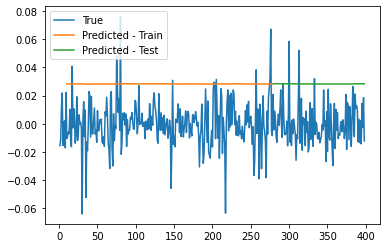

Epochs:  500  Iterations:  1503  Loss:  0.00032621852005831897
Epochs:  1000  Iterations:  3003  Loss:  0.0003595559683162719
Epochs:  1500  Iterations:  4503  Loss:  0.00020440398414696878
Epochs:  2000  Iterations:  6003  Loss:  0.0001777131765265949
Epochs:  2500  Iterations:  7503  Loss:  0.0002595784462755546
Epochs:  3000  Iterations:  9003  Loss:  0.0001617472250169764
Epochs:  3500  Iterations:  10503  Loss:  0.0001946515500700722
Epochs:  4000  Iterations:  12003  Loss:  0.00019156382525882995
Epochs:  4500  Iterations:  13503  Loss:  0.00034802890149876475
Epochs:  5000  Iterations:  15003  Loss:  0.0002430377498967573
Epochs:  5500  Iterations:  16503  Loss:  0.0002874639758374542
Epochs:  6000  Iterations:  18003  Loss:  0.00028751623661567766
Epochs:  6500  Iterations:  19503  Loss:  0.00014426377674681135
Epochs:  7000  Iterations:  21003  Loss:  0.0002744121205372115
Epochs:  7500  Iterations:  22503  Loss:  0.00024711610361312825
Epochs:  8000  Iterations:  24003  Loss:

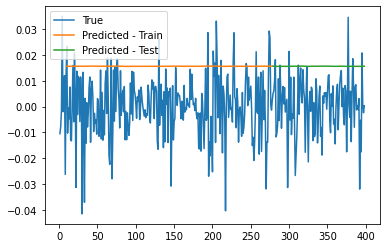

Epochs:  500  Iterations:  1503  Loss:  0.00012288568298875666
Epochs:  1000  Iterations:  3003  Loss:  0.00016470972574704015
Epochs:  1500  Iterations:  4503  Loss:  0.00014871046975410232
Epochs:  2000  Iterations:  6003  Loss:  0.00010419247701065615
Epochs:  2500  Iterations:  7503  Loss:  0.00011956186062889174
Epochs:  3000  Iterations:  9003  Loss:  0.00011511099728522822
Epochs:  3500  Iterations:  10503  Loss:  0.0001402585306398881
Epochs:  4000  Iterations:  12003  Loss:  0.00011289178170651819
Epochs:  4500  Iterations:  13503  Loss:  7.056293088680832e-05
Epochs:  5000  Iterations:  15003  Loss:  8.90161506201063e-05
Epochs:  5500  Iterations:  16503  Loss:  6.052833009562164e-05
Epochs:  6000  Iterations:  18003  Loss:  7.50931916021121e-05
Epochs:  6500  Iterations:  19503  Loss:  5.038357172300797e-05
Epochs:  7000  Iterations:  21003  Loss:  5.257776388134516e-05
Epochs:  7500  Iterations:  22503  Loss:  9.900164392699178e-05
Epochs:  8000  Iterations:  24003  Loss:  

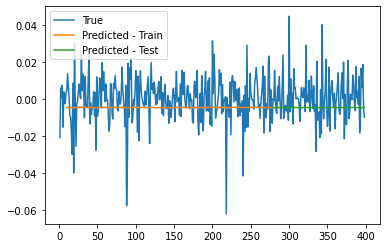

Epochs:  500  Iterations:  1503  Loss:  0.00014499224198516458
Epochs:  1000  Iterations:  3003  Loss:  0.00013342490031694373
Epochs:  1500  Iterations:  4503  Loss:  0.00011372585019368368
Epochs:  2000  Iterations:  6003  Loss:  0.00010311944364123822
Epochs:  2500  Iterations:  7503  Loss:  8.97142142548546e-05
Epochs:  3000  Iterations:  9003  Loss:  0.00012829306069761515
Epochs:  3500  Iterations:  10503  Loss:  0.00010300259115562464
Epochs:  4000  Iterations:  12003  Loss:  9.842078482809787e-05
Epochs:  4500  Iterations:  13503  Loss:  5.680852685448675e-05
Epochs:  5000  Iterations:  15003  Loss:  8.466519617892725e-05
Epochs:  5500  Iterations:  16503  Loss:  8.689676603050127e-05
Epochs:  6000  Iterations:  18003  Loss:  2.0855126498039073e-05
Epochs:  6500  Iterations:  19503  Loss:  1.2463046308160605e-05
Epochs:  7000  Iterations:  21003  Loss:  4.644710774511414e-07
Epochs:  7500  Iterations:  22503  Loss:  9.613663494908072e-08
Epochs:  8000  Iterations:  24003  Loss:

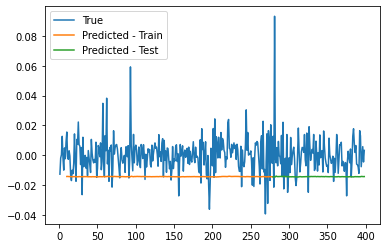

Epochs:  500  Iterations:  1503  Loss:  0.0001701201569327774
Epochs:  1000  Iterations:  3003  Loss:  0.0001103909113832439
Epochs:  1500  Iterations:  4503  Loss:  9.032866789008646e-05
Epochs:  2000  Iterations:  6003  Loss:  5.6636636524369045e-05
Epochs:  2500  Iterations:  7503  Loss:  6.672284583449557e-05
Epochs:  3000  Iterations:  9003  Loss:  4.596399564131085e-05
Epochs:  3500  Iterations:  10503  Loss:  2.3554679197938338e-05
Epochs:  4000  Iterations:  12003  Loss:  1.0182634089990946e-05
Epochs:  4500  Iterations:  13503  Loss:  6.562222173063977e-05
Epochs:  5000  Iterations:  15003  Loss:  1.5841168107044723e-05
Epochs:  5500  Iterations:  16503  Loss:  7.11543519097783e-06
Epochs:  6000  Iterations:  18003  Loss:  3.860389733745251e-05
Epochs:  6500  Iterations:  19503  Loss:  1.0137418954059285e-05
Epochs:  7000  Iterations:  21003  Loss:  9.730540189896904e-07
Epochs:  7500  Iterations:  22503  Loss:  2.7438009359078325e-05
Epochs:  8000  Iterations:  24003  Loss:  

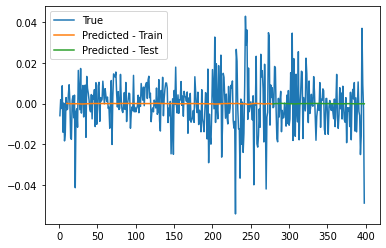

Epochs:  500  Iterations:  1503  Loss:  0.00020481415655619153
Epochs:  1000  Iterations:  3003  Loss:  0.00013805637960710251
Epochs:  1500  Iterations:  4503  Loss:  0.00011263198515128654
Epochs:  2000  Iterations:  6003  Loss:  0.00013445202785078436
Epochs:  2500  Iterations:  7503  Loss:  0.00016751669318182394
Epochs:  3000  Iterations:  9003  Loss:  0.00011189544117466237
Epochs:  3500  Iterations:  10503  Loss:  7.675114655588307e-05
Epochs:  4000  Iterations:  12003  Loss:  8.46228537435915e-05
Epochs:  4500  Iterations:  13503  Loss:  7.045144942215605e-05
Epochs:  5000  Iterations:  15003  Loss:  7.057684403359114e-05
Epochs:  5500  Iterations:  16503  Loss:  6.490724596612078e-05
Epochs:  6000  Iterations:  18003  Loss:  4.6160392021950734e-05
Epochs:  6500  Iterations:  19503  Loss:  3.596926156509047e-05
Epochs:  7000  Iterations:  21003  Loss:  1.6788113650060648e-05
Epochs:  7500  Iterations:  22503  Loss:  8.993830533654545e-06
Epochs:  8000  Iterations:  24003  Loss:

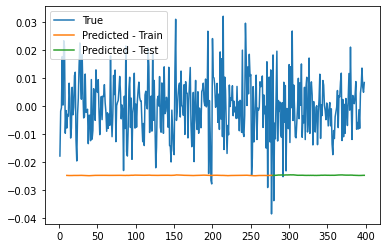

Epochs:  500  Iterations:  1503  Loss:  0.00016090354377714297
Epochs:  1000  Iterations:  3003  Loss:  0.00015409430003880212
Epochs:  1500  Iterations:  4503  Loss:  0.0001516241876136822
Epochs:  2000  Iterations:  6003  Loss:  9.109395493093568e-05
Epochs:  2500  Iterations:  7503  Loss:  8.448459387485248e-05
Epochs:  3000  Iterations:  9003  Loss:  5.3332975160932015e-05
Epochs:  3500  Iterations:  10503  Loss:  4.0166415980517435e-05
Epochs:  4000  Iterations:  12003  Loss:  3.890165059298548e-05
Epochs:  4500  Iterations:  13503  Loss:  2.3890960013280466e-05
Epochs:  5000  Iterations:  15003  Loss:  1.7218677688409418e-05
Epochs:  5500  Iterations:  16503  Loss:  1.3437578369727513e-05
Epochs:  6000  Iterations:  18003  Loss:  1.1138913957135324e-05
Epochs:  6500  Iterations:  19503  Loss:  4.420982852100981e-06
Epochs:  7000  Iterations:  21003  Loss:  3.3608844868619294e-06
Epochs:  7500  Iterations:  22503  Loss:  8.515708335229041e-06
Epochs:  8000  Iterations:  24003  Los

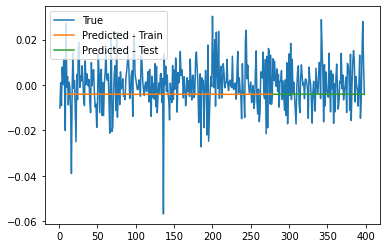

Epochs:  500  Iterations:  1503  Loss:  0.00011660852275478344
Epochs:  1000  Iterations:  3003  Loss:  0.00011408631204782675
Epochs:  1500  Iterations:  4503  Loss:  9.456218200890969e-05
Epochs:  2000  Iterations:  6003  Loss:  9.29549933061935e-05
Epochs:  2500  Iterations:  7503  Loss:  8.339949393606123e-05
Epochs:  3000  Iterations:  9003  Loss:  6.700072268965111e-05
Epochs:  3500  Iterations:  10503  Loss:  5.5487414821679217e-05
Epochs:  4000  Iterations:  12003  Loss:  5.092661372903725e-05
Epochs:  4500  Iterations:  13503  Loss:  4.736369741446348e-05
Epochs:  5000  Iterations:  15003  Loss:  3.9679097426414955e-05
Epochs:  5500  Iterations:  16503  Loss:  2.4614633275632514e-05
Epochs:  6000  Iterations:  18003  Loss:  8.613084961931843e-05
Epochs:  6500  Iterations:  19503  Loss:  4.3992748487653444e-05
Epochs:  7000  Iterations:  21003  Loss:  3.9167563500086544e-05
Epochs:  7500  Iterations:  22503  Loss:  8.630083470961836e-06
Epochs:  8000  Iterations:  24003  Loss: 

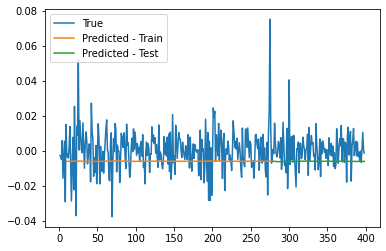

Epochs:  500  Iterations:  1503  Loss:  0.00029033926208891597
Epochs:  1000  Iterations:  3003  Loss:  0.0001961721015201571
Epochs:  1500  Iterations:  4503  Loss:  0.0002131424359201143
Epochs:  2000  Iterations:  6003  Loss:  0.00012896523306456706
Epochs:  2500  Iterations:  7503  Loss:  0.00021408020499317595
Epochs:  3000  Iterations:  9003  Loss:  6.33898331822517e-05
Epochs:  3500  Iterations:  10503  Loss:  4.276865972011971e-05
Epochs:  4000  Iterations:  12003  Loss:  3.6320160688774195e-05
Epochs:  4500  Iterations:  13503  Loss:  2.5563191002220265e-05
Epochs:  5000  Iterations:  15003  Loss:  3.764658595173387e-05
Epochs:  5500  Iterations:  16503  Loss:  1.4177491133674872e-05
Epochs:  6000  Iterations:  18003  Loss:  1.4297498031131303e-05
Epochs:  6500  Iterations:  19503  Loss:  4.7617396793005655e-06
Epochs:  7000  Iterations:  21003  Loss:  3.570789241772824e-06
Epochs:  7500  Iterations:  22503  Loss:  5.086356671772189e-07
Epochs:  8000  Iterations:  24003  Loss:

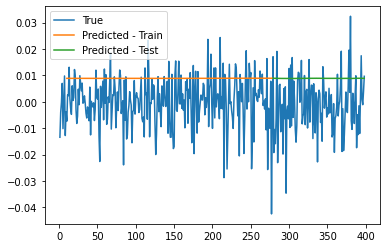

Epochs:  500  Iterations:  1503  Loss:  0.00012988221715204418
Epochs:  1000  Iterations:  3003  Loss:  0.0001230493580806069
Epochs:  1500  Iterations:  4503  Loss:  0.00012669554174256822
Epochs:  2000  Iterations:  6003  Loss:  0.00012214884433584908
Epochs:  2500  Iterations:  7503  Loss:  8.451170288026333e-05
Epochs:  3000  Iterations:  9003  Loss:  7.602579717058688e-05
Epochs:  3500  Iterations:  10503  Loss:  7.416514078310381e-05
Epochs:  4000  Iterations:  12003  Loss:  4.0614949322540873e-05
Epochs:  4500  Iterations:  13503  Loss:  3.639458524655007e-05
Epochs:  5000  Iterations:  15003  Loss:  4.3215265426018355e-05
Epochs:  5500  Iterations:  16503  Loss:  2.666581591862875e-05
Epochs:  6000  Iterations:  18003  Loss:  2.045729547717201e-05
Epochs:  6500  Iterations:  19503  Loss:  4.5256511536232814e-05
Epochs:  7000  Iterations:  21003  Loss:  1.093729095676584e-05
Epochs:  7500  Iterations:  22503  Loss:  1.0742203661114521e-05
Epochs:  8000  Iterations:  24003  Loss:

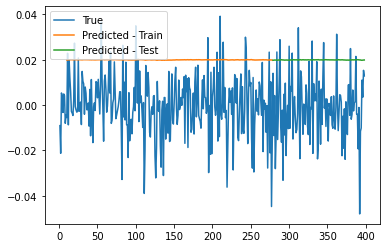

Epochs:  500  Iterations:  1503  Loss:  0.00022565412897771844
Epochs:  1000  Iterations:  3003  Loss:  0.00016985584322052696
Epochs:  1500  Iterations:  4503  Loss:  0.00017886096611618996
Epochs:  2000  Iterations:  6003  Loss:  0.00011314648266610068
Epochs:  2500  Iterations:  7503  Loss:  0.00011446552404474157
Epochs:  3000  Iterations:  9003  Loss:  8.35554743995696e-05
Epochs:  3500  Iterations:  10503  Loss:  0.00025674657566317666
Epochs:  4000  Iterations:  12003  Loss:  0.00011750437018539135
Epochs:  4500  Iterations:  13503  Loss:  8.652082548602873e-05
Epochs:  5000  Iterations:  15003  Loss:  8.214250859358192e-05
Epochs:  5500  Iterations:  16503  Loss:  3.4224734463350615e-05
Epochs:  6000  Iterations:  18003  Loss:  6.299546960993514e-05
Epochs:  6500  Iterations:  19503  Loss:  7.549479596491437e-05
Epochs:  7000  Iterations:  21003  Loss:  7.179734833092273e-05
Epochs:  7500  Iterations:  22503  Loss:  2.3655086200354464e-05
Epochs:  8000  Iterations:  24003  Loss

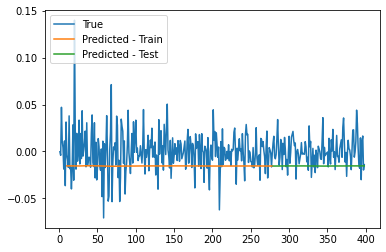

Epochs:  500  Iterations:  1503  Loss:  0.00036841071657060337
Epochs:  1000  Iterations:  3003  Loss:  0.00034713301768836874
Epochs:  1500  Iterations:  4503  Loss:  0.0003127868646212543
Epochs:  2000  Iterations:  6003  Loss:  0.0002991952909117875
Epochs:  2500  Iterations:  7503  Loss:  0.00029028452505978447
Epochs:  3000  Iterations:  9003  Loss:  0.0002603176192981967
Epochs:  3500  Iterations:  10503  Loss:  0.0002830339035426732
Epochs:  4000  Iterations:  12003  Loss:  0.00024558450968470424
Epochs:  4500  Iterations:  13503  Loss:  0.0003122508812036055
Epochs:  5000  Iterations:  15003  Loss:  0.00024756368475209456
Epochs:  5500  Iterations:  16503  Loss:  0.00021624976746655497
Epochs:  6000  Iterations:  18003  Loss:  0.00017934569495992037
Epochs:  6500  Iterations:  19503  Loss:  0.00018031245175128183
Epochs:  7000  Iterations:  21003  Loss:  9.369103645440191e-05
Epochs:  7500  Iterations:  22503  Loss:  8.19343228310269e-05
Epochs:  8000  Iterations:  24003  Loss:

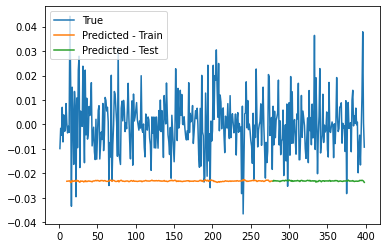

Epochs:  500  Iterations:  1503  Loss:  0.00014576072862837464
Epochs:  1000  Iterations:  3003  Loss:  0.00011014231131412089
Epochs:  1500  Iterations:  4503  Loss:  0.00010135857034280586
Epochs:  2000  Iterations:  6003  Loss:  7.497941669498687e-05
Epochs:  2500  Iterations:  7503  Loss:  0.00010799819331926604
Epochs:  3000  Iterations:  9003  Loss:  7.81724635695961e-05
Epochs:  3500  Iterations:  10503  Loss:  7.379764489693723e-05
Epochs:  4000  Iterations:  12003  Loss:  6.59624832527091e-05
Epochs:  4500  Iterations:  13503  Loss:  4.7653383565678574e-05
Epochs:  5000  Iterations:  15003  Loss:  2.626163738265556e-05
Epochs:  5500  Iterations:  16503  Loss:  1.5609198423286823e-05
Epochs:  6000  Iterations:  18003  Loss:  1.2055028491886333e-05
Epochs:  6500  Iterations:  19503  Loss:  3.365354662795047e-06
Epochs:  7000  Iterations:  21003  Loss:  5.388569472112674e-06
Epochs:  7500  Iterations:  22503  Loss:  1.9657599295896944e-05
Epochs:  8000  Iterations:  24003  Loss: 

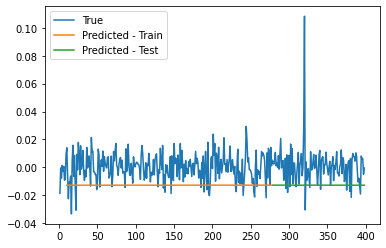

Epochs:  500  Iterations:  1503  Loss:  9.908003751964618e-05
Epochs:  1000  Iterations:  3003  Loss:  9.727598080644384e-05
Epochs:  1500  Iterations:  4503  Loss:  8.778417395660654e-05
Epochs:  2000  Iterations:  6003  Loss:  6.71777033858234e-05
Epochs:  2500  Iterations:  7503  Loss:  6.285777453740593e-05
Epochs:  3000  Iterations:  9003  Loss:  5.73358302062843e-05
Epochs:  3500  Iterations:  10503  Loss:  7.683631459561487e-05
Epochs:  4000  Iterations:  12003  Loss:  6.476697065712263e-05
Epochs:  4500  Iterations:  13503  Loss:  4.9437926084768456e-05
Epochs:  5000  Iterations:  15003  Loss:  4.740349193828782e-05
Epochs:  5500  Iterations:  16503  Loss:  4.460005758725553e-05
Epochs:  6000  Iterations:  18003  Loss:  4.0231162586223945e-05
Epochs:  6500  Iterations:  19503  Loss:  5.485421570483595e-05
Epochs:  7000  Iterations:  21003  Loss:  3.1743140425533056e-05
Epochs:  7500  Iterations:  22503  Loss:  3.0854613138823574e-05
Epochs:  8000  Iterations:  24003  Loss:  1.6

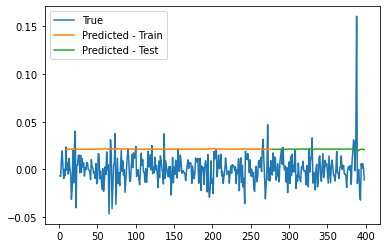

Epochs:  500  Iterations:  1503  Loss:  0.00020076234553319713
Epochs:  1000  Iterations:  3003  Loss:  0.00012901344659136763
Epochs:  1500  Iterations:  4503  Loss:  0.00012037422857247293
Epochs:  2000  Iterations:  6003  Loss:  0.00010378999271172991
Epochs:  2500  Iterations:  7503  Loss:  9.969658519063766e-05
Epochs:  3000  Iterations:  9003  Loss:  9.038204674046331e-05
Epochs:  3500  Iterations:  10503  Loss:  6.881818838640659e-05
Epochs:  4000  Iterations:  12003  Loss:  0.00018459666656175008
Epochs:  4500  Iterations:  13503  Loss:  0.0001460715308591413
Epochs:  5000  Iterations:  15003  Loss:  6.185651242655392e-05
Epochs:  5500  Iterations:  16503  Loss:  3.396934736580685e-05
Epochs:  6000  Iterations:  18003  Loss:  1.42175219176958e-05
Epochs:  6500  Iterations:  19503  Loss:  0.0001792830735212192
Epochs:  7000  Iterations:  21003  Loss:  7.993038540613877e-05
Epochs:  7500  Iterations:  22503  Loss:  6.289683058942804e-05
Epochs:  8000  Iterations:  24003  Loss:  4

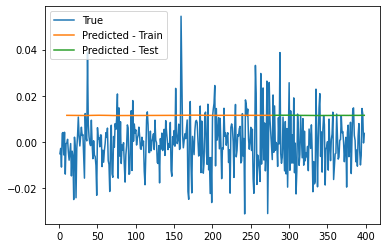

Epochs:  500  Iterations:  1503  Loss:  0.0001579012411336104
Epochs:  1000  Iterations:  3003  Loss:  0.00011520493474866574
Epochs:  1500  Iterations:  4503  Loss:  0.00011035460192942992
Epochs:  2000  Iterations:  6003  Loss:  8.620791353071884e-05
Epochs:  2500  Iterations:  7503  Loss:  7.463173703096497e-05
Epochs:  3000  Iterations:  9003  Loss:  5.6893175648535056e-05
Epochs:  3500  Iterations:  10503  Loss:  5.833419863658188e-05
Epochs:  4000  Iterations:  12003  Loss:  4.4657657402543315e-05
Epochs:  4500  Iterations:  13503  Loss:  2.1993003727516225e-05
Epochs:  5000  Iterations:  15003  Loss:  1.9562683064577868e-05
Epochs:  5500  Iterations:  16503  Loss:  1.0665997857965218e-05
Epochs:  6000  Iterations:  18003  Loss:  4.754748564058294e-06
Epochs:  6500  Iterations:  19503  Loss:  2.5354782688206495e-07
Epochs:  7000  Iterations:  21003  Loss:  8.444288160565824e-07
Epochs:  7500  Iterations:  22503  Loss:  7.255938214711932e-07
Epochs:  8000  Iterations:  24003  Loss

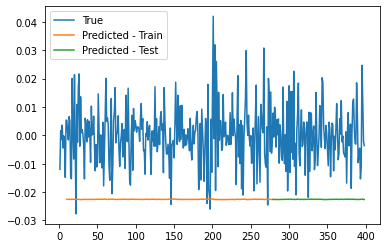

Epochs:  500  Iterations:  1503  Loss:  0.0001389462073954443
Epochs:  1000  Iterations:  3003  Loss:  0.00010823822958627716
Epochs:  1500  Iterations:  4503  Loss:  8.354751965574299e-05
Epochs:  2000  Iterations:  6003  Loss:  7.306476375864197e-05
Epochs:  2500  Iterations:  7503  Loss:  6.789453436795156e-05
Epochs:  3000  Iterations:  9003  Loss:  4.8717566945318445e-05
Epochs:  3500  Iterations:  10503  Loss:  7.067482086616413e-05
Epochs:  4000  Iterations:  12003  Loss:  7.200349318736698e-05
Epochs:  4500  Iterations:  13503  Loss:  3.664786557540841e-05
Epochs:  5000  Iterations:  15003  Loss:  2.927320171390117e-05
Epochs:  5500  Iterations:  16503  Loss:  1.2983693807200325e-05
Epochs:  6000  Iterations:  18003  Loss:  2.104007535308483e-05
Epochs:  6500  Iterations:  19503  Loss:  9.549064240369868e-06
Epochs:  7000  Iterations:  21003  Loss:  3.339533880838038e-05
Epochs:  7500  Iterations:  22503  Loss:  2.1156468127022285e-06
Epochs:  8000  Iterations:  24003  Loss:  1

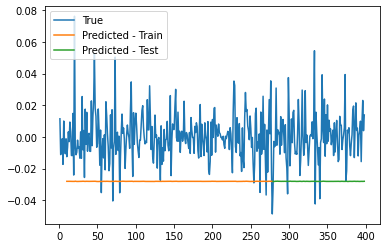

Epochs:  500  Iterations:  1503  Loss:  0.00026155727391596884
Epochs:  1000  Iterations:  3003  Loss:  0.0002216993598267436
Epochs:  1500  Iterations:  4503  Loss:  0.00018936459673568606
Epochs:  2000  Iterations:  6003  Loss:  0.00019859025875727335
Epochs:  2500  Iterations:  7503  Loss:  0.0001539503391541075
Epochs:  3000  Iterations:  9003  Loss:  0.00022126297214223692
Epochs:  3500  Iterations:  10503  Loss:  0.00014921526720475717
Epochs:  4000  Iterations:  12003  Loss:  0.00016911742204683833
Epochs:  4500  Iterations:  13503  Loss:  0.00014619230326691954
Epochs:  5000  Iterations:  15003  Loss:  0.0001312523739519141
Epochs:  5500  Iterations:  16503  Loss:  0.00015855690071475692
Epochs:  6000  Iterations:  18003  Loss:  0.00013277168181957677
Epochs:  6500  Iterations:  19503  Loss:  0.00014965895267475085
Epochs:  7000  Iterations:  21003  Loss:  0.00012558425820922517
Epochs:  7500  Iterations:  22503  Loss:  0.00018832218484021723
Epochs:  8000  Iterations:  24003  

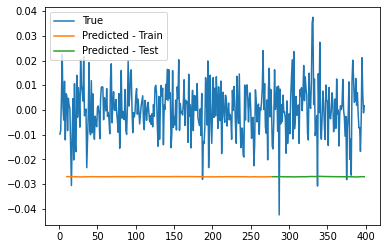

Epochs:  500  Iterations:  1503  Loss:  9.291578317061067e-05
Epochs:  1000  Iterations:  3003  Loss:  7.514327201837052e-05
Epochs:  1500  Iterations:  4503  Loss:  7.208566603367217e-05
Epochs:  2000  Iterations:  6003  Loss:  7.205504759137209e-05
Epochs:  2500  Iterations:  7503  Loss:  5.791327809371675e-05
Epochs:  3000  Iterations:  9003  Loss:  5.233220629937326e-05
Epochs:  3500  Iterations:  10503  Loss:  7.095467420488906e-05
Epochs:  4000  Iterations:  12003  Loss:  6.0215629976786054e-05
Epochs:  4500  Iterations:  13503  Loss:  4.8132702431757934e-05
Epochs:  5000  Iterations:  15003  Loss:  3.545019580049787e-05
Epochs:  5500  Iterations:  16503  Loss:  8.043087776362275e-05
Epochs:  6000  Iterations:  18003  Loss:  4.400490085269363e-05
Epochs:  6500  Iterations:  19503  Loss:  4.5100127560241766e-05
Epochs:  7000  Iterations:  21003  Loss:  2.7671830196140945e-05
Epochs:  7500  Iterations:  22503  Loss:  3.708661430816088e-05
Epochs:  8000  Iterations:  24003  Loss:  2

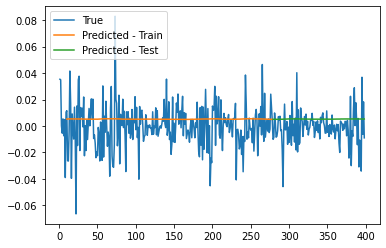

Epochs:  500  Iterations:  1503  Loss:  0.00021362914655279988
Epochs:  1000  Iterations:  3003  Loss:  0.00017781160446853997
Epochs:  1500  Iterations:  4503  Loss:  0.00016293667492088085
Epochs:  2000  Iterations:  6003  Loss:  9.146717729890952e-05
Epochs:  2500  Iterations:  7503  Loss:  6.804154683474432e-05
Epochs:  3000  Iterations:  9003  Loss:  7.45267473879115e-05
Epochs:  3500  Iterations:  10503  Loss:  4.197271073280717e-05
Epochs:  4000  Iterations:  12003  Loss:  1.9789808618497773e-05
Epochs:  4500  Iterations:  13503  Loss:  7.225391698284511e-06
Epochs:  5000  Iterations:  15003  Loss:  3.154290662147711e-06
Epochs:  5500  Iterations:  16503  Loss:  1.9374599863416126e-05
Epochs:  6000  Iterations:  18003  Loss:  1.129435067544667e-06
Epochs:  6500  Iterations:  19503  Loss:  1.5110819940507743e-06
Epochs:  7000  Iterations:  21003  Loss:  5.8731055598097255e-06
Epochs:  7500  Iterations:  22503  Loss:  6.431572579697805e-07
Epochs:  8000  Iterations:  24003  Loss: 

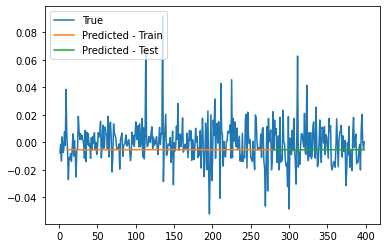

Epochs:  500  Iterations:  1503  Loss:  0.00020526744871555516
Epochs:  1000  Iterations:  3003  Loss:  0.00019222208356950432
Epochs:  1500  Iterations:  4503  Loss:  0.0001410118020430673
Epochs:  2000  Iterations:  6003  Loss:  0.00020960363326594234
Epochs:  2500  Iterations:  7503  Loss:  0.00019348908002333096
Epochs:  3000  Iterations:  9003  Loss:  0.00018997664543955276
Epochs:  3500  Iterations:  10503  Loss:  0.00015843971292876327
Epochs:  4000  Iterations:  12003  Loss:  0.00014224781019341512
Epochs:  4500  Iterations:  13503  Loss:  0.00017637820322609818
Epochs:  5000  Iterations:  15003  Loss:  0.00011279460250079865
Epochs:  5500  Iterations:  16503  Loss:  0.0001398784649306132
Epochs:  6000  Iterations:  18003  Loss:  0.00011739125572300206
Epochs:  6500  Iterations:  19503  Loss:  0.00011237199555580446
Epochs:  7000  Iterations:  21003  Loss:  0.00011780151119940759
Epochs:  7500  Iterations:  22503  Loss:  0.0001150351151106103
Epochs:  8000  Iterations:  24003  

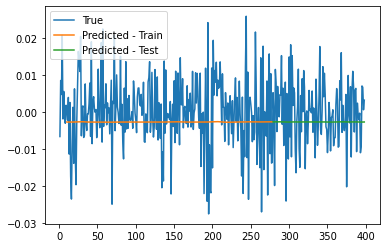

Epochs:  500  Iterations:  1503  Loss:  0.00010730967430087428
Epochs:  1000  Iterations:  3003  Loss:  7.666112530084017e-05
Epochs:  1500  Iterations:  4503  Loss:  7.338225138179648e-05
Epochs:  2000  Iterations:  6003  Loss:  6.292668028133146e-05
Epochs:  2500  Iterations:  7503  Loss:  6.459001936794569e-05
Epochs:  3000  Iterations:  9003  Loss:  5.304455983908459e-05
Epochs:  3500  Iterations:  10503  Loss:  4.820333909568338e-05
Epochs:  4000  Iterations:  12003  Loss:  4.101019699949878e-05
Epochs:  4500  Iterations:  13503  Loss:  3.72331908427744e-05
Epochs:  5000  Iterations:  15003  Loss:  4.7446450480492786e-05
Epochs:  5500  Iterations:  16503  Loss:  3.3603957338831e-05
Epochs:  6000  Iterations:  18003  Loss:  5.622905943406901e-05
Epochs:  6500  Iterations:  19503  Loss:  7.307051419047639e-05
Epochs:  7000  Iterations:  21003  Loss:  1.468786332026184e-05
Epochs:  7500  Iterations:  22503  Loss:  5.065645874916906e-06
Epochs:  8000  Iterations:  24003  Loss:  2.2664

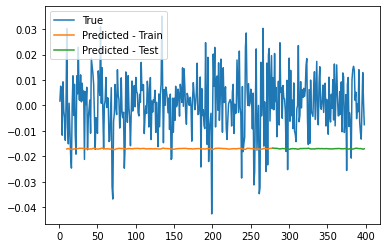

Epochs:  500  Iterations:  1503  Loss:  0.0001737537580387046
Epochs:  1000  Iterations:  3003  Loss:  0.00013768282224191353
Epochs:  1500  Iterations:  4503  Loss:  0.0001918975952624654
Epochs:  2000  Iterations:  6003  Loss:  9.187863088300219e-05
Epochs:  2500  Iterations:  7503  Loss:  0.00013580189018587893
Epochs:  3000  Iterations:  9003  Loss:  0.00010361009784295068
Epochs:  3500  Iterations:  10503  Loss:  9.009281870930863e-05
Epochs:  4000  Iterations:  12003  Loss:  8.72339742272743e-05
Epochs:  4500  Iterations:  13503  Loss:  6.160029670354561e-05
Epochs:  5000  Iterations:  15003  Loss:  3.867974229857888e-05
Epochs:  5500  Iterations:  16503  Loss:  3.7028200040367665e-05
Epochs:  6000  Iterations:  18003  Loss:  2.11357076598991e-05
Epochs:  6500  Iterations:  19503  Loss:  1.3411959950341648e-05
Epochs:  7000  Iterations:  21003  Loss:  4.175650891132439e-06
Epochs:  7500  Iterations:  22503  Loss:  1.8803422605628839e-06
Epochs:  8000  Iterations:  24003  Loss:  4

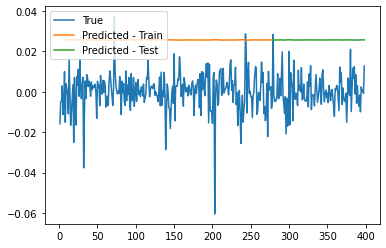

Epochs:  500  Iterations:  1503  Loss:  9.020921667494501e-05
Epochs:  1000  Iterations:  3003  Loss:  8.376240778792028e-05
Epochs:  1500  Iterations:  4503  Loss:  7.789025282060417e-05
Epochs:  2000  Iterations:  6003  Loss:  7.112623886011231e-05
Epochs:  2500  Iterations:  7503  Loss:  7.755852978637752e-05
Epochs:  3000  Iterations:  9003  Loss:  7.342216849792749e-05
Epochs:  3500  Iterations:  10503  Loss:  7.270758457404251e-05
Epochs:  4000  Iterations:  12003  Loss:  7.131240757492681e-05
Epochs:  4500  Iterations:  13503  Loss:  7.050624481053092e-05
Epochs:  5000  Iterations:  15003  Loss:  6.741266164074962e-05
Epochs:  5500  Iterations:  16503  Loss:  6.76322585301629e-05
Epochs:  6000  Iterations:  18003  Loss:  0.00011368146321425836
Epochs:  6500  Iterations:  19503  Loss:  5.6010250167067475e-05
Epochs:  7000  Iterations:  21003  Loss:  5.002922459122298e-05
Epochs:  7500  Iterations:  22503  Loss:  5.028014296234081e-05
Epochs:  8000  Iterations:  24003  Loss:  5.01

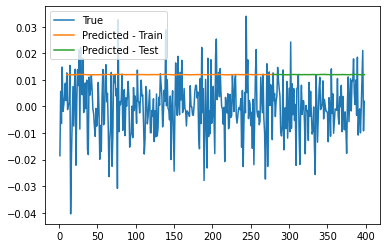

Epochs:  500  Iterations:  1503  Loss:  0.0001314247322928471
Epochs:  1000  Iterations:  3003  Loss:  0.00011484290735097602
Epochs:  1500  Iterations:  4503  Loss:  0.00010776033741421998
Epochs:  2000  Iterations:  6003  Loss:  7.989088650598812e-05
Epochs:  2500  Iterations:  7503  Loss:  5.3715986420381036e-05
Epochs:  3000  Iterations:  9003  Loss:  8.2357998204922e-05
Epochs:  3500  Iterations:  10503  Loss:  3.9143699761249685e-05
Epochs:  4000  Iterations:  12003  Loss:  4.1467785498146746e-05
Epochs:  4500  Iterations:  13503  Loss:  3.288736843387596e-05
Epochs:  5000  Iterations:  15003  Loss:  1.358296761585128e-05
Epochs:  5500  Iterations:  16503  Loss:  1.086879214540204e-05
Epochs:  6000  Iterations:  18003  Loss:  5.140314669915824e-06
Epochs:  6500  Iterations:  19503  Loss:  8.49551664335498e-06
Epochs:  7000  Iterations:  21003  Loss:  2.952196145618776e-06
Epochs:  7500  Iterations:  22503  Loss:  1.7352646371667408e-06
Epochs:  8000  Iterations:  24003  Loss:  1.

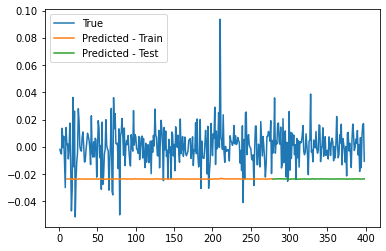

Epochs:  500  Iterations:  1503  Loss:  0.0001935768911304573
Epochs:  1000  Iterations:  3003  Loss:  0.00015757077320207222
Epochs:  1500  Iterations:  4503  Loss:  0.00018037774376959229
Epochs:  2000  Iterations:  6003  Loss:  0.00014444656214133525
Epochs:  2500  Iterations:  7503  Loss:  0.00012146406758499022
Epochs:  3000  Iterations:  9003  Loss:  0.00011686831900685017
Epochs:  3500  Iterations:  10503  Loss:  8.568198033268952e-05
Epochs:  4000  Iterations:  12003  Loss:  0.00010698145160858985
Epochs:  4500  Iterations:  13503  Loss:  9.906437056391344e-05
Epochs:  5000  Iterations:  15003  Loss:  3.339992116480062e-05
Epochs:  5500  Iterations:  16503  Loss:  1.715735841874751e-05
Epochs:  6000  Iterations:  18003  Loss:  7.256667026922514e-05
Epochs:  6500  Iterations:  19503  Loss:  5.138495741145258e-05
Epochs:  7000  Iterations:  21003  Loss:  8.265867351534932e-05
Epochs:  7500  Iterations:  22503  Loss:  5.240526813092098e-05
Epochs:  8000  Iterations:  24003  Loss: 

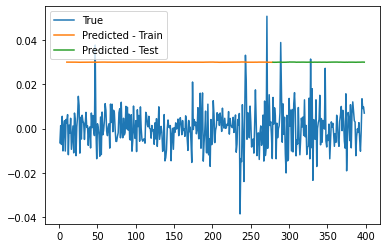

Epochs:  500  Iterations:  1503  Loss:  0.00014007695305432813
Epochs:  1000  Iterations:  3003  Loss:  0.00010259566139817859
Epochs:  1500  Iterations:  4503  Loss:  8.107148945176353e-05
Epochs:  2000  Iterations:  6003  Loss:  6.250120350159705e-05
Epochs:  2500  Iterations:  7503  Loss:  6.068456787033938e-05
Epochs:  3000  Iterations:  9003  Loss:  6.117606487047549e-05
Epochs:  3500  Iterations:  10503  Loss:  6.511211419516864e-05
Epochs:  4000  Iterations:  12003  Loss:  5.8768060019550226e-05
Epochs:  4500  Iterations:  13503  Loss:  5.538096471961277e-05
Epochs:  5000  Iterations:  15003  Loss:  5.4508253621558346e-05
Epochs:  5500  Iterations:  16503  Loss:  5.415461722198719e-05
Epochs:  6000  Iterations:  18003  Loss:  5.323636590522559e-05
Epochs:  6500  Iterations:  19503  Loss:  5.078202593722381e-05
Epochs:  7000  Iterations:  21003  Loss:  4.786560566572007e-05
Epochs:  7500  Iterations:  22503  Loss:  4.5770977521897294e-05
Epochs:  8000  Iterations:  24003  Loss:  

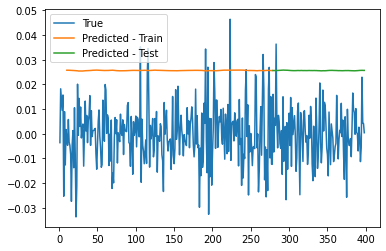

Epochs:  500  Iterations:  1503  Loss:  0.00015951876897209635
Epochs:  1000  Iterations:  3003  Loss:  0.00011290936163277365
Epochs:  1500  Iterations:  4503  Loss:  8.813069689495023e-05
Epochs:  2000  Iterations:  6003  Loss:  7.223110696941148e-05
Epochs:  2500  Iterations:  7503  Loss:  6.386756361583441e-05
Epochs:  3000  Iterations:  9003  Loss:  5.626172886271282e-05
Epochs:  3500  Iterations:  10503  Loss:  5.019322460005545e-05
Epochs:  4000  Iterations:  12003  Loss:  5.269545848326137e-05
Epochs:  4500  Iterations:  13503  Loss:  4.796649894463675e-05
Epochs:  5000  Iterations:  15003  Loss:  3.127984380550212e-05
Epochs:  5500  Iterations:  16503  Loss:  2.517719610750646e-05
Epochs:  6000  Iterations:  18003  Loss:  1.944232129365749e-05
Epochs:  6500  Iterations:  19503  Loss:  1.1809294316359834e-05
Epochs:  7000  Iterations:  21003  Loss:  8.570355655971676e-06
Epochs:  7500  Iterations:  22503  Loss:  0.00019466616019296149
Epochs:  8000  Iterations:  24003  Loss:  8

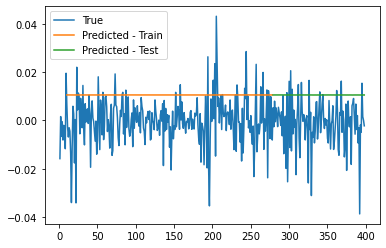

Epochs:  500  Iterations:  1503  Loss:  9.871727767555664e-05
Epochs:  1000  Iterations:  3003  Loss:  9.59429550372685e-05
Epochs:  1500  Iterations:  4503  Loss:  8.233060119285558e-05
Epochs:  2000  Iterations:  6003  Loss:  6.934193515917286e-05
Epochs:  2500  Iterations:  7503  Loss:  5.989805686112959e-05
Epochs:  3000  Iterations:  9003  Loss:  8.348925378716861e-05
Epochs:  3500  Iterations:  10503  Loss:  5.530330387652308e-05
Epochs:  4000  Iterations:  12003  Loss:  4.077297163955033e-05
Epochs:  4500  Iterations:  13503  Loss:  3.194539400889577e-05
Epochs:  5000  Iterations:  15003  Loss:  2.273937796341367e-05
Epochs:  5500  Iterations:  16503  Loss:  1.34874730216931e-05
Epochs:  6000  Iterations:  18003  Loss:  2.8358840609143954e-05
Epochs:  6500  Iterations:  19503  Loss:  3.77676169591723e-05
Epochs:  7000  Iterations:  21003  Loss:  1.981676795518676e-05
Epochs:  7500  Iterations:  22503  Loss:  8.872066492434291e-06
Epochs:  8000  Iterations:  24003  Loss:  1.19707

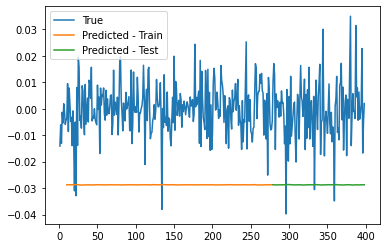

Epochs:  500  Iterations:  1503  Loss:  8.779845666140318e-05
Epochs:  1000  Iterations:  3003  Loss:  8.740626556876425e-05
Epochs:  1500  Iterations:  4503  Loss:  8.695689029991627e-05
Epochs:  2000  Iterations:  6003  Loss:  8.662201192540427e-05
Epochs:  2500  Iterations:  7503  Loss:  8.388375620900963e-05
Epochs:  3000  Iterations:  9003  Loss:  8.340120014812176e-05
Epochs:  3500  Iterations:  10503  Loss:  7.955280064682786e-05
Epochs:  4000  Iterations:  12003  Loss:  7.31038126104977e-05
Epochs:  4500  Iterations:  13503  Loss:  6.424917895249867e-05
Epochs:  5000  Iterations:  15003  Loss:  6.084830480782936e-05
Epochs:  5500  Iterations:  16503  Loss:  5.225050275233419e-05
Epochs:  6000  Iterations:  18003  Loss:  8.43352706093962e-05
Epochs:  6500  Iterations:  19503  Loss:  8.177620232648526e-05
Epochs:  7000  Iterations:  21003  Loss:  7.745345404449229e-05
Epochs:  7500  Iterations:  22503  Loss:  5.393098914889075e-05
Epochs:  8000  Iterations:  24003  Loss:  7.54703

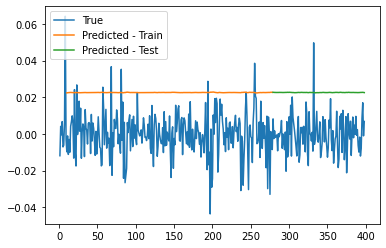

Epochs:  500  Iterations:  1503  Loss:  0.00015017567299461612
Epochs:  1000  Iterations:  3003  Loss:  0.00012708528811344877
Epochs:  1500  Iterations:  4503  Loss:  0.00013141672146351388
Epochs:  2000  Iterations:  6003  Loss:  0.00012179444820503704
Epochs:  2500  Iterations:  7503  Loss:  0.0001120300742816956
Epochs:  3000  Iterations:  9003  Loss:  9.974208175359915e-05
Epochs:  3500  Iterations:  10503  Loss:  0.00011663848514823864
Epochs:  4000  Iterations:  12003  Loss:  9.41180951485876e-05
Epochs:  4500  Iterations:  13503  Loss:  8.618578794994392e-05
Epochs:  5000  Iterations:  15003  Loss:  8.090623805401265e-05
Epochs:  5500  Iterations:  16503  Loss:  7.461294440721152e-05
Epochs:  6000  Iterations:  18003  Loss:  7.270923530692623e-05
Epochs:  6500  Iterations:  19503  Loss:  0.00013880680489819497
Epochs:  7000  Iterations:  21003  Loss:  9.730041529110167e-05
Epochs:  7500  Iterations:  22503  Loss:  9.182481699099299e-05
Epochs:  8000  Iterations:  24003  Loss:  

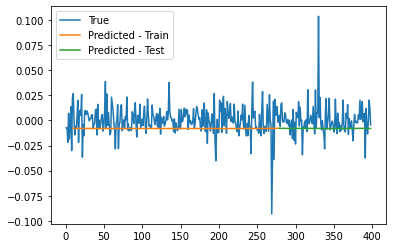

Epochs:  500  Iterations:  1503  Loss:  0.00031960692528324824
Epochs:  1000  Iterations:  3003  Loss:  0.00038381662549606216
Epochs:  1500  Iterations:  4503  Loss:  0.0002506882350038116
Epochs:  2000  Iterations:  6003  Loss:  0.00019979213539045304
Epochs:  2500  Iterations:  7503  Loss:  0.0001729045131166155
Epochs:  3000  Iterations:  9003  Loss:  7.436897855465456e-05
Epochs:  3500  Iterations:  10503  Loss:  6.764704297287001e-05
Epochs:  4000  Iterations:  12003  Loss:  7.48331513023004e-05
Epochs:  4500  Iterations:  13503  Loss:  0.00028163482299229753
Epochs:  5000  Iterations:  15003  Loss:  0.0001276702096220106
Epochs:  5500  Iterations:  16503  Loss:  5.786420115327928e-05
Epochs:  6000  Iterations:  18003  Loss:  8.43552309864511e-05
Epochs:  6500  Iterations:  19503  Loss:  3.910468141536209e-05
Epochs:  7000  Iterations:  21003  Loss:  3.0449529125083547e-05
Epochs:  7500  Iterations:  22503  Loss:  3.820682438041937e-05
Epochs:  8000  Iterations:  24003  Loss:  3.

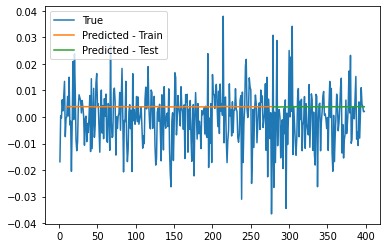

Epochs:  500  Iterations:  1503  Loss:  0.00013636155684556192
Epochs:  1000  Iterations:  3003  Loss:  0.0001208176909130998
Epochs:  1500  Iterations:  4503  Loss:  9.995734581025317e-05
Epochs:  2000  Iterations:  6003  Loss:  8.500030162394978e-05
Epochs:  2500  Iterations:  7503  Loss:  0.00011697359635339429
Epochs:  3000  Iterations:  9003  Loss:  7.165696297306567e-05
Epochs:  3500  Iterations:  10503  Loss:  9.286103644020234e-05
Epochs:  4000  Iterations:  12003  Loss:  6.86460813691762e-05
Epochs:  4500  Iterations:  13503  Loss:  9.783631685422733e-05
Epochs:  5000  Iterations:  15003  Loss:  0.00010663256883465995
Epochs:  5500  Iterations:  16503  Loss:  5.3928120754183816e-05
Epochs:  6000  Iterations:  18003  Loss:  4.3912316262625005e-05
Epochs:  6500  Iterations:  19503  Loss:  2.2859443220113462e-05
Epochs:  7000  Iterations:  21003  Loss:  8.59439205195637e-06
Epochs:  7500  Iterations:  22503  Loss:  6.272832687651923e-06
Epochs:  8000  Iterations:  24003  Loss:  3

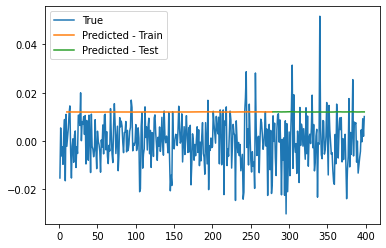

Epochs:  500  Iterations:  1503  Loss:  9.807389384756486e-05
Epochs:  1000  Iterations:  3003  Loss:  8.881889759019639e-05
Epochs:  1500  Iterations:  4503  Loss:  8.350112814999495e-05
Epochs:  2000  Iterations:  6003  Loss:  6.598756954190321e-05
Epochs:  2500  Iterations:  7503  Loss:  5.0258809399868674e-05
Epochs:  3000  Iterations:  9003  Loss:  4.321702848149774e-05
Epochs:  3500  Iterations:  10503  Loss:  3.451104809452469e-05
Epochs:  4000  Iterations:  12003  Loss:  2.9147729795416428e-05
Epochs:  4500  Iterations:  13503  Loss:  2.4091092200251296e-05
Epochs:  5000  Iterations:  15003  Loss:  1.3108004319898706e-05
Epochs:  5500  Iterations:  16503  Loss:  5.763037506767432e-06
Epochs:  6000  Iterations:  18003  Loss:  3.539241796109612e-05
Epochs:  6500  Iterations:  19503  Loss:  1.6215517158949904e-05
Epochs:  7000  Iterations:  21003  Loss:  8.485751095577143e-06
Epochs:  7500  Iterations:  22503  Loss:  1.5011788339810057e-06
Epochs:  8000  Iterations:  24003  Loss: 

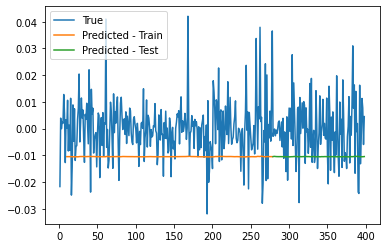

Epochs:  500  Iterations:  1503  Loss:  0.00010312694697252785
Epochs:  1000  Iterations:  3003  Loss:  7.811982322891708e-05
Epochs:  1500  Iterations:  4503  Loss:  6.953947104193503e-05
Epochs:  2000  Iterations:  6003  Loss:  6.215822410619391e-05
Epochs:  2500  Iterations:  7503  Loss:  6.302618233651931e-05
Epochs:  3000  Iterations:  9003  Loss:  3.962979889138296e-05
Epochs:  3500  Iterations:  10503  Loss:  2.738837338730112e-05
Epochs:  4000  Iterations:  12003  Loss:  1.9228435652015225e-05
Epochs:  4500  Iterations:  13503  Loss:  1.2808448824822941e-05
Epochs:  5000  Iterations:  15003  Loss:  2.5085849794474293e-06
Epochs:  5500  Iterations:  16503  Loss:  2.569919274719723e-06
Epochs:  6000  Iterations:  18003  Loss:  1.8759375943015282e-06
Epochs:  6500  Iterations:  19503  Loss:  2.5554731640416626e-06
Epochs:  7000  Iterations:  21003  Loss:  1.71307320329106e-07
Epochs:  7500  Iterations:  22503  Loss:  2.3912904130914586e-07
Epochs:  8000  Iterations:  24003  Loss: 

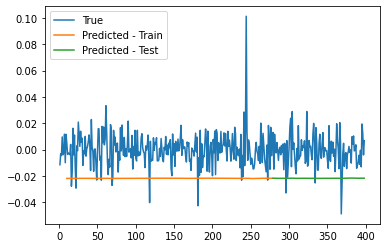

Epochs:  500  Iterations:  1503  Loss:  0.00015575019157646844
Epochs:  1000  Iterations:  3003  Loss:  0.00013211470165212327
Epochs:  1500  Iterations:  4503  Loss:  0.00012740962968867583
Epochs:  2000  Iterations:  6003  Loss:  0.00010420526359666837
Epochs:  2500  Iterations:  7503  Loss:  0.00010038820892077638
Epochs:  3000  Iterations:  9003  Loss:  0.00010234165923369194
Epochs:  3500  Iterations:  10503  Loss:  7.438951312603119e-05
Epochs:  4000  Iterations:  12003  Loss:  0.0001914800814120099
Epochs:  4500  Iterations:  13503  Loss:  0.00010910834043897921
Epochs:  5000  Iterations:  15003  Loss:  0.00011507180655219902
Epochs:  5500  Iterations:  16503  Loss:  0.00011339907390113997
Epochs:  6000  Iterations:  18003  Loss:  0.00012412991903450651
Epochs:  6500  Iterations:  19503  Loss:  0.00010464897180402961
Epochs:  7000  Iterations:  21003  Loss:  0.00011605235643704266
Epochs:  7500  Iterations:  22503  Loss:  9.601270933975077e-05
Epochs:  8000  Iterations:  24003  

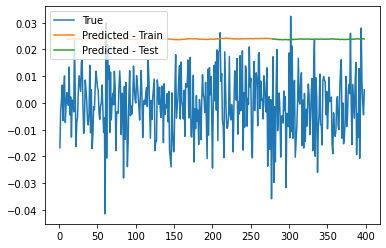

Epochs:  500  Iterations:  1503  Loss:  0.00013562163561194515
Epochs:  1000  Iterations:  3003  Loss:  0.00012591092430132753
Epochs:  1500  Iterations:  4503  Loss:  0.00011476875564161067
Epochs:  2000  Iterations:  6003  Loss:  0.00011536567520427828
Epochs:  2500  Iterations:  7503  Loss:  0.0001257898038602434
Epochs:  3000  Iterations:  9003  Loss:  7.721619143315668e-05
Epochs:  3500  Iterations:  10503  Loss:  6.657397602793935e-05
Epochs:  4000  Iterations:  12003  Loss:  6.297360475097473e-05
Epochs:  4500  Iterations:  13503  Loss:  7.3315730332979e-05
Epochs:  5000  Iterations:  15003  Loss:  3.174584416380336e-05
Epochs:  5500  Iterations:  16503  Loss:  1.950444785355406e-05
Epochs:  6000  Iterations:  18003  Loss:  3.0496077670250088e-05
Epochs:  6500  Iterations:  19503  Loss:  3.220353708736449e-06
Epochs:  7000  Iterations:  21003  Loss:  1.9996087180137088e-06
Epochs:  7500  Iterations:  22503  Loss:  1.3474294367673185e-06
Epochs:  8000  Iterations:  24003  Loss:  

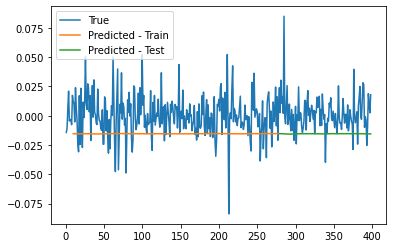

Epochs:  500  Iterations:  1503  Loss:  0.00027376740278365713
Epochs:  1000  Iterations:  3003  Loss:  0.00027085592834434163
Epochs:  1500  Iterations:  4503  Loss:  0.00026144565587552887
Epochs:  2000  Iterations:  6003  Loss:  0.0002666621730895713
Epochs:  2500  Iterations:  7503  Loss:  0.0002918431176415955
Epochs:  3000  Iterations:  9003  Loss:  0.00022841238387627527
Epochs:  3500  Iterations:  10503  Loss:  0.0001843690091239599
Epochs:  4000  Iterations:  12003  Loss:  0.00016912873616092838
Epochs:  4500  Iterations:  13503  Loss:  9.463500555284554e-05
Epochs:  5000  Iterations:  15003  Loss:  0.00011003722480988169
Epochs:  5500  Iterations:  16503  Loss:  3.2877636272132804e-05
Epochs:  6000  Iterations:  18003  Loss:  4.0047340310896594e-05
Epochs:  6500  Iterations:  19503  Loss:  0.00011204669362996356
Epochs:  7000  Iterations:  21003  Loss:  3.5371818967178115e-05
Epochs:  7500  Iterations:  22503  Loss:  1.7654618356270173e-05
Epochs:  8000  Iterations:  24003  L

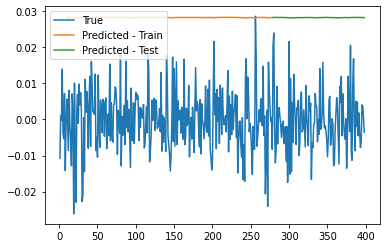

Epochs:  500  Iterations:  1503  Loss:  8.663290888459112e-05
Epochs:  1000  Iterations:  3003  Loss:  7.732868349800508e-05
Epochs:  1500  Iterations:  4503  Loss:  6.985984267278884e-05
Epochs:  2000  Iterations:  6003  Loss:  7.186671185384814e-05
Epochs:  2500  Iterations:  7503  Loss:  5.569363505249688e-05
Epochs:  3000  Iterations:  9003  Loss:  6.044506881153211e-05
Epochs:  3500  Iterations:  10503  Loss:  3.7520856115709954e-05
Epochs:  4000  Iterations:  12003  Loss:  3.5626602160239905e-05
Epochs:  4500  Iterations:  13503  Loss:  3.649399801967471e-05
Epochs:  5000  Iterations:  15003  Loss:  2.9740840697437914e-05
Epochs:  5500  Iterations:  16503  Loss:  2.2618951258361147e-05
Epochs:  6000  Iterations:  18003  Loss:  2.408613909210544e-05
Epochs:  6500  Iterations:  19503  Loss:  6.572410347871482e-05
Epochs:  7000  Iterations:  21003  Loss:  3.727858150644655e-05
Epochs:  7500  Iterations:  22503  Loss:  2.8675317253146204e-05
Epochs:  8000  Iterations:  24003  Loss:  

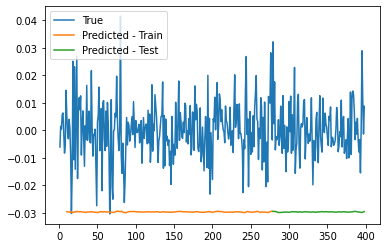

Epochs:  500  Iterations:  1503  Loss:  0.00012271947343833745
Epochs:  1000  Iterations:  3003  Loss:  0.0001236933603649959
Epochs:  1500  Iterations:  4503  Loss:  9.144412251771428e-05
Epochs:  2000  Iterations:  6003  Loss:  8.291476478916593e-05
Epochs:  2500  Iterations:  7503  Loss:  7.387552856622885e-05
Epochs:  3000  Iterations:  9003  Loss:  6.65229199512396e-05
Epochs:  3500  Iterations:  10503  Loss:  9.610566000143687e-05
Epochs:  4000  Iterations:  12003  Loss:  7.460064686407956e-05
Epochs:  4500  Iterations:  13503  Loss:  7.277217082446441e-05
Epochs:  5000  Iterations:  15003  Loss:  7.280128799417677e-05
Epochs:  5500  Iterations:  16503  Loss:  6.648525474399018e-05
Epochs:  6000  Iterations:  18003  Loss:  0.00022599781126094362
Epochs:  6500  Iterations:  19503  Loss:  4.960976919695289e-05
Epochs:  7000  Iterations:  21003  Loss:  4.369711147470904e-05
Epochs:  7500  Iterations:  22503  Loss:  3.1449092404045587e-05
Epochs:  8000  Iterations:  24003  Loss:  1.1

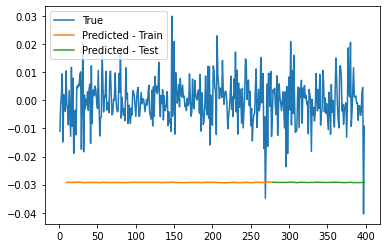

Epochs:  500  Iterations:  1503  Loss:  8.825510788786535e-05
Epochs:  1000  Iterations:  3003  Loss:  7.364987686742097e-05
Epochs:  1500  Iterations:  4503  Loss:  9.904513353831135e-05
Epochs:  2000  Iterations:  6003  Loss:  7.743543392280117e-05
Epochs:  2500  Iterations:  7503  Loss:  7.143788873994102e-05
Epochs:  3000  Iterations:  9003  Loss:  7.044059141965893e-05
Epochs:  3500  Iterations:  10503  Loss:  7.088833081070334e-05
Epochs:  4000  Iterations:  12003  Loss:  6.854344489208113e-05
Epochs:  4500  Iterations:  13503  Loss:  6.564675883661646e-05
Epochs:  5000  Iterations:  15003  Loss:  6.023056024181036e-05
Epochs:  5500  Iterations:  16503  Loss:  9.119367920599568e-05
Epochs:  6000  Iterations:  18003  Loss:  6.983444594273654e-05
Epochs:  6500  Iterations:  19503  Loss:  5.674277175179062e-05
Epochs:  7000  Iterations:  21003  Loss:  7.393707104104881e-05
Epochs:  7500  Iterations:  22503  Loss:  5.468602891293509e-05
Epochs:  8000  Iterations:  24003  Loss:  6.470

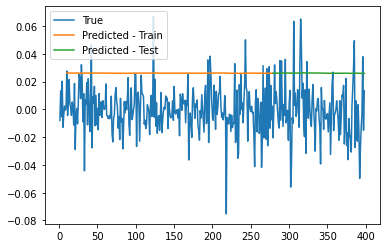

Epochs:  500  Iterations:  1503  Loss:  0.0002339700828694428
Epochs:  1000  Iterations:  3003  Loss:  0.00022789935367958
Epochs:  1500  Iterations:  4503  Loss:  0.00019527247786754742
Epochs:  2000  Iterations:  6003  Loss:  0.00021326726952490085
Epochs:  2500  Iterations:  7503  Loss:  0.00019493249419610947
Epochs:  3000  Iterations:  9003  Loss:  0.00014610423325696806
Epochs:  3500  Iterations:  10503  Loss:  0.00015882329656354463
Epochs:  4000  Iterations:  12003  Loss:  6.458581871508311e-05
Epochs:  4500  Iterations:  13503  Loss:  7.1955456538338085e-06
Epochs:  5000  Iterations:  15003  Loss:  1.432421925073868e-06
Epochs:  5500  Iterations:  16503  Loss:  5.464941568789072e-05
Epochs:  6000  Iterations:  18003  Loss:  3.757691516744396e-08
Epochs:  6500  Iterations:  19503  Loss:  3.035101533062819e-07
Epochs:  7000  Iterations:  21003  Loss:  4.5256177353773336e-07
Epochs:  7500  Iterations:  22503  Loss:  7.863582709433103e-07
Epochs:  8000  Iterations:  24003  Loss:  

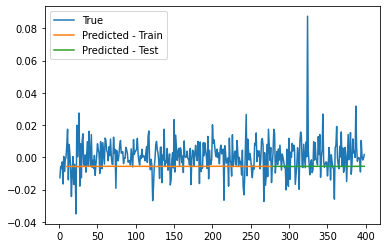

Epochs:  500  Iterations:  1503  Loss:  0.00010727991563423227
Epochs:  1000  Iterations:  3003  Loss:  0.00010003722369826089
Epochs:  1500  Iterations:  4503  Loss:  8.682206195468704e-05
Epochs:  2000  Iterations:  6003  Loss:  7.205098518170416e-05
Epochs:  2500  Iterations:  7503  Loss:  6.340051792600813e-05
Epochs:  3000  Iterations:  9003  Loss:  3.9112986542022554e-05
Epochs:  3500  Iterations:  10503  Loss:  5.6775446258446514e-05
Epochs:  4000  Iterations:  12003  Loss:  3.0609643242011465e-05
Epochs:  4500  Iterations:  13503  Loss:  2.181191479166955e-05
Epochs:  5000  Iterations:  15003  Loss:  2.0090043629276504e-05
Epochs:  5500  Iterations:  16503  Loss:  1.8566527605419953e-05
Epochs:  6000  Iterations:  18003  Loss:  2.294975403553205e-05
Epochs:  6500  Iterations:  19503  Loss:  2.4408076190714684e-05
Epochs:  7000  Iterations:  21003  Loss:  4.63099780271629e-06
Epochs:  7500  Iterations:  22503  Loss:  4.212765200387973e-06
Epochs:  8000  Iterations:  24003  Loss:

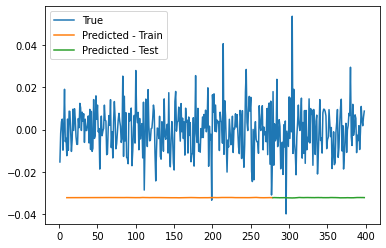

Epochs:  500  Iterations:  1503  Loss:  0.000131831696004762
Epochs:  1000  Iterations:  3003  Loss:  0.0001282763017419105
Epochs:  1500  Iterations:  4503  Loss:  0.0001191082046716474
Epochs:  2000  Iterations:  6003  Loss:  0.00010810122815504049
Epochs:  2500  Iterations:  7503  Loss:  8.478660189818281e-05
Epochs:  3000  Iterations:  9003  Loss:  7.673453395303416e-05
Epochs:  3500  Iterations:  10503  Loss:  5.0216107789916954e-05
Epochs:  4000  Iterations:  12003  Loss:  4.7453123367328466e-05
Epochs:  4500  Iterations:  13503  Loss:  4.648453947690238e-05
Epochs:  5000  Iterations:  15003  Loss:  3.7491588348833225e-05
Epochs:  5500  Iterations:  16503  Loss:  2.809808442331511e-05
Epochs:  6000  Iterations:  18003  Loss:  2.5710534108232725e-05
Epochs:  6500  Iterations:  19503  Loss:  1.590189219768945e-05
Epochs:  7000  Iterations:  21003  Loss:  3.072831843079863e-05
Epochs:  7500  Iterations:  22503  Loss:  2.6018233332555003e-05
Epochs:  8000  Iterations:  24003  Loss:  

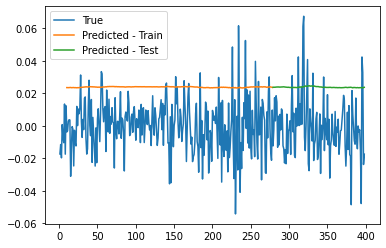

Epochs:  500  Iterations:  1503  Loss:  0.00024193518523437282
Epochs:  1000  Iterations:  3003  Loss:  0.00020969116546136016
Epochs:  1500  Iterations:  4503  Loss:  0.00020290505684291324
Epochs:  2000  Iterations:  6003  Loss:  0.00018352957583071353
Epochs:  2500  Iterations:  7503  Loss:  0.00016084665367088746
Epochs:  3000  Iterations:  9003  Loss:  0.00011653549487770458
Epochs:  3500  Iterations:  10503  Loss:  8.615295246272581e-05
Epochs:  4000  Iterations:  12003  Loss:  7.44088595941624e-05
Epochs:  4500  Iterations:  13503  Loss:  6.453873114272331e-05
Epochs:  5000  Iterations:  15003  Loss:  5.639158916892484e-05
Epochs:  5500  Iterations:  16503  Loss:  1.7064336589101003e-05
Epochs:  6000  Iterations:  18003  Loss:  3.3758829639888668e-06
Epochs:  6500  Iterations:  19503  Loss:  1.5629826824200183e-05
Epochs:  7000  Iterations:  21003  Loss:  2.1235071471892297e-05
Epochs:  7500  Iterations:  22503  Loss:  2.705534476869313e-05
Epochs:  8000  Iterations:  24003  Los

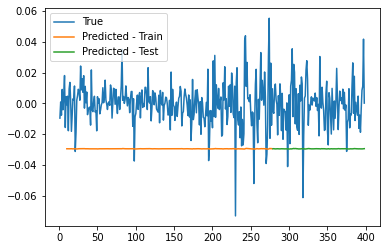

Epochs:  500  Iterations:  1503  Loss:  0.00027723790844902396
Epochs:  1000  Iterations:  3003  Loss:  0.0001886556225751216
Epochs:  1500  Iterations:  4503  Loss:  0.00012222625688688518
Epochs:  2000  Iterations:  6003  Loss:  9.730046531331027e-05
Epochs:  2500  Iterations:  7503  Loss:  8.24268481665058e-05
Epochs:  3000  Iterations:  9003  Loss:  9.835813549822585e-05
Epochs:  3500  Iterations:  10503  Loss:  9.888421179008826e-05
Epochs:  4000  Iterations:  12003  Loss:  7.873027486008748e-05
Epochs:  4500  Iterations:  13503  Loss:  4.369173673997769e-05
Epochs:  5000  Iterations:  15003  Loss:  4.17038843162724e-05
Epochs:  5500  Iterations:  16503  Loss:  0.0003132050502851295
Epochs:  6000  Iterations:  18003  Loss:  0.00014978643109013015
Epochs:  6500  Iterations:  19503  Loss:  0.00010375847826556613
Epochs:  7000  Iterations:  21003  Loss:  0.00011759752184540655
Epochs:  7500  Iterations:  22503  Loss:  0.00024279963205723712
Epochs:  8000  Iterations:  24003  Loss:  0

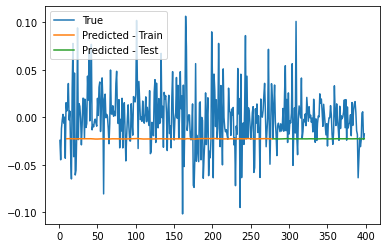

Epochs:  500  Iterations:  1503  Loss:  0.0007993383381593352
Epochs:  1000  Iterations:  3003  Loss:  0.0006796808374929242
Epochs:  1500  Iterations:  4503  Loss:  0.000517169507171881
Epochs:  2000  Iterations:  6003  Loss:  0.00047213820410737145
Epochs:  2500  Iterations:  7503  Loss:  0.0002533211603198045
Epochs:  3000  Iterations:  9003  Loss:  0.00013049494070097958
Epochs:  3500  Iterations:  10503  Loss:  2.0049352845793084e-05
Epochs:  4000  Iterations:  12003  Loss:  8.515845214181658e-06
Epochs:  4500  Iterations:  13503  Loss:  0.00014996689181619635
Epochs:  5000  Iterations:  15003  Loss:  3.735712645417758e-05
Epochs:  5500  Iterations:  16503  Loss:  1.938968262038543e-05
Epochs:  6000  Iterations:  18003  Loss:  2.802451907276312e-06
Epochs:  6500  Iterations:  19503  Loss:  4.2781547904269246e-07
Epochs:  7000  Iterations:  21003  Loss:  3.297249198906208e-08
Epochs:  7500  Iterations:  22503  Loss:  4.0860540195808426e-07
Epochs:  8000  Iterations:  24003  Loss:  

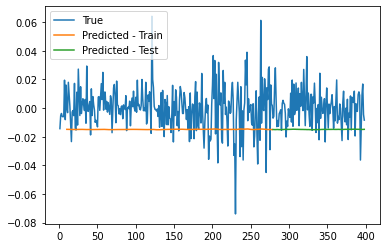

Epochs:  500  Iterations:  1503  Loss:  0.0002747073255401726
Epochs:  1000  Iterations:  3003  Loss:  0.0002781568085386728
Epochs:  1500  Iterations:  4503  Loss:  0.00023470501764677465
Epochs:  2000  Iterations:  6003  Loss:  0.00015877909451470865
Epochs:  2500  Iterations:  7503  Loss:  0.00022388416982721537
Epochs:  3000  Iterations:  9003  Loss:  0.00018003807781497017
Epochs:  3500  Iterations:  10503  Loss:  0.00015332550356106367
Epochs:  4000  Iterations:  12003  Loss:  0.0001254862090718234
Epochs:  4500  Iterations:  13503  Loss:  0.0001101758104293064
Epochs:  5000  Iterations:  15003  Loss:  0.00012846147971382985
Epochs:  5500  Iterations:  16503  Loss:  9.483539480470426e-05
Epochs:  6000  Iterations:  18003  Loss:  7.814064036892887e-05
Epochs:  6500  Iterations:  19503  Loss:  7.000181312832865e-05
Epochs:  7000  Iterations:  21003  Loss:  7.806349822203629e-05
Epochs:  7500  Iterations:  22503  Loss:  3.4213123171866755e-05
Epochs:  8000  Iterations:  24003  Loss:

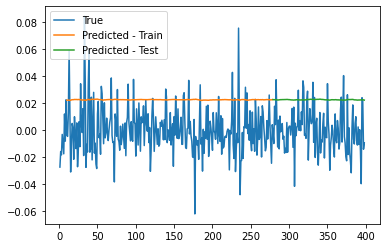

Epochs:  500  Iterations:  1503  Loss:  0.00025275068522508565
Epochs:  1000  Iterations:  3003  Loss:  0.000240446999669075
Epochs:  1500  Iterations:  4503  Loss:  0.00022146906849229708
Epochs:  2000  Iterations:  6003  Loss:  0.00021313133644677387
Epochs:  2500  Iterations:  7503  Loss:  0.00018296504398070587
Epochs:  3000  Iterations:  9003  Loss:  0.0001892443190930256
Epochs:  3500  Iterations:  10503  Loss:  0.00010854607019912994
Epochs:  4000  Iterations:  12003  Loss:  3.1464718669364324e-05
Epochs:  4500  Iterations:  13503  Loss:  6.875239705550484e-06
Epochs:  5000  Iterations:  15003  Loss:  4.45798686996568e-05
Epochs:  5500  Iterations:  16503  Loss:  1.3512234128635707e-06
Epochs:  6000  Iterations:  18003  Loss:  1.8302684452464746e-06
Epochs:  6500  Iterations:  19503  Loss:  3.314217463431154e-08
Epochs:  7000  Iterations:  21003  Loss:  6.167912564099727e-06
Epochs:  7500  Iterations:  22503  Loss:  3.630569077965144e-07
Epochs:  8000  Iterations:  24003  Loss: 

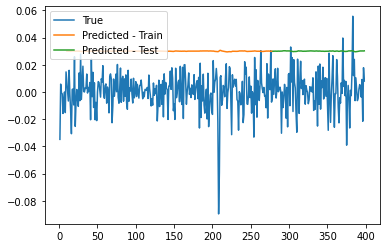

Epochs:  500  Iterations:  1503  Loss:  0.00017786252283258364
Epochs:  1000  Iterations:  3003  Loss:  0.00017436225122461715
Epochs:  1500  Iterations:  4503  Loss:  0.00017192459684641412
Epochs:  2000  Iterations:  6003  Loss:  0.00016867840410365412
Epochs:  2500  Iterations:  7503  Loss:  0.00015175826410995796
Epochs:  3000  Iterations:  9003  Loss:  0.00010172475746609659
Epochs:  3500  Iterations:  10503  Loss:  5.1351416232137126e-05
Epochs:  4000  Iterations:  12003  Loss:  2.1812190955946182e-05
Epochs:  4500  Iterations:  13503  Loss:  5.438255811895942e-06
Epochs:  5000  Iterations:  15003  Loss:  3.4256893286510604e-06
Epochs:  5500  Iterations:  16503  Loss:  1.2546717774360634e-06
Epochs:  6000  Iterations:  18003  Loss:  1.4271714690039516e-06
Epochs:  6500  Iterations:  19503  Loss:  5.101760128430518e-07
Epochs:  7000  Iterations:  21003  Loss:  4.850587842497589e-08
Epochs:  7500  Iterations:  22503  Loss:  5.225172442872387e-09
Epochs:  8000  Iterations:  24003  L

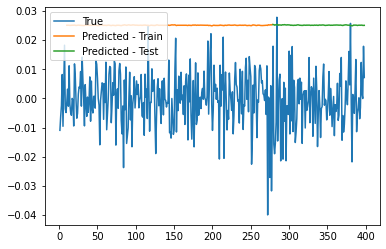

Epochs:  500  Iterations:  1503  Loss:  0.00012497303153698644
Epochs:  1000  Iterations:  3003  Loss:  0.00012312908559882393
Epochs:  1500  Iterations:  4503  Loss:  0.00013286699443900338
Epochs:  2000  Iterations:  6003  Loss:  0.00010741061608617504
Epochs:  2500  Iterations:  7503  Loss:  0.00012212391690506288
Epochs:  3000  Iterations:  9003  Loss:  9.80986939490928e-05
Epochs:  3500  Iterations:  10503  Loss:  0.0001172367628896609
Epochs:  4000  Iterations:  12003  Loss:  0.00011520303451106884
Epochs:  4500  Iterations:  13503  Loss:  0.00010356417381747936
Epochs:  5000  Iterations:  15003  Loss:  8.125570699727784e-05
Epochs:  5500  Iterations:  16503  Loss:  8.222999167628586e-05
Epochs:  6000  Iterations:  18003  Loss:  8.13879329750004e-05
Epochs:  6500  Iterations:  19503  Loss:  7.461551770878334e-05
Epochs:  7000  Iterations:  21003  Loss:  7.27303571087153e-05
Epochs:  7500  Iterations:  22503  Loss:  0.00011272972672789668
Epochs:  8000  Iterations:  24003  Loss:  

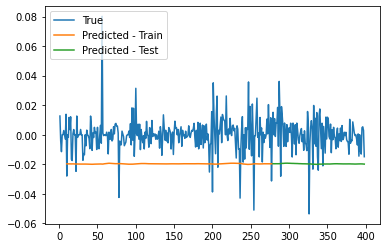

Epochs:  500  Iterations:  1503  Loss:  0.00013147760667682937
Epochs:  1000  Iterations:  3003  Loss:  0.00011801448999904096
Epochs:  1500  Iterations:  4503  Loss:  0.00011727183058004205
Epochs:  2000  Iterations:  6003  Loss:  0.00010000492208443272
Epochs:  2500  Iterations:  7503  Loss:  0.00010554287776661415
Epochs:  3000  Iterations:  9003  Loss:  0.00012532459368230775
Epochs:  3500  Iterations:  10503  Loss:  9.697090717963874e-05
Epochs:  4000  Iterations:  12003  Loss:  8.40874502803975e-05
Epochs:  4500  Iterations:  13503  Loss:  5.8821601669478696e-05
Epochs:  5000  Iterations:  15003  Loss:  4.1093779448904875e-05
Epochs:  5500  Iterations:  16503  Loss:  2.5428479223895312e-05
Epochs:  6000  Iterations:  18003  Loss:  9.720124095717135e-05
Epochs:  6500  Iterations:  19503  Loss:  0.00012000335846096277
Epochs:  7000  Iterations:  21003  Loss:  0.0001064209354808554
Epochs:  7500  Iterations:  22503  Loss:  8.689179170081236e-05
Epochs:  8000  Iterations:  24003  Los

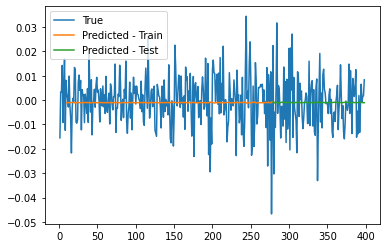

Epochs:  500  Iterations:  1503  Loss:  0.00013979122983679795
Epochs:  1000  Iterations:  3003  Loss:  0.00014535027488212413
Epochs:  1500  Iterations:  4503  Loss:  8.361899381270632e-05
Epochs:  2000  Iterations:  6003  Loss:  6.482080546750997e-05
Epochs:  2500  Iterations:  7503  Loss:  6.526923849984693e-05
Epochs:  3000  Iterations:  9003  Loss:  4.0834998496090215e-05
Epochs:  3500  Iterations:  10503  Loss:  5.3510898093615346e-05
Epochs:  4000  Iterations:  12003  Loss:  2.0017686078214563e-05
Epochs:  4500  Iterations:  13503  Loss:  1.5869085776406184e-05
Epochs:  5000  Iterations:  15003  Loss:  1.4815393418151265e-05
Epochs:  5500  Iterations:  16503  Loss:  5.8034957722459995e-06
Epochs:  6000  Iterations:  18003  Loss:  2.9746537772249817e-06
Epochs:  6500  Iterations:  19503  Loss:  3.552581498903843e-06
Epochs:  7000  Iterations:  21003  Loss:  6.649734226963725e-07
Epochs:  7500  Iterations:  22503  Loss:  3.300538689169722e-06
Epochs:  8000  Iterations:  24003  Los

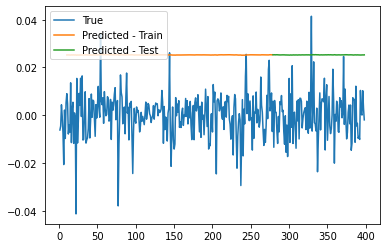

Epochs:  500  Iterations:  1503  Loss:  7.694983166099216e-05
Epochs:  1000  Iterations:  3003  Loss:  6.828603727626614e-05
Epochs:  1500  Iterations:  4503  Loss:  5.960154521744698e-05
Epochs:  2000  Iterations:  6003  Loss:  5.5492094664562806e-05
Epochs:  2500  Iterations:  7503  Loss:  5.303452113973132e-05
Epochs:  3000  Iterations:  9003  Loss:  4.403602482246546e-05
Epochs:  3500  Iterations:  10503  Loss:  4.1599959937836196e-05
Epochs:  4000  Iterations:  12003  Loss:  3.144073616567766e-05
Epochs:  4500  Iterations:  13503  Loss:  3.19973113770781e-05
Epochs:  5000  Iterations:  15003  Loss:  3.1551890363819744e-05
Epochs:  5500  Iterations:  16503  Loss:  2.587746511532411e-05
Epochs:  6000  Iterations:  18003  Loss:  4.425973899439365e-05
Epochs:  6500  Iterations:  19503  Loss:  2.6540902884638246e-05
Epochs:  7000  Iterations:  21003  Loss:  5.514681167066252e-05
Epochs:  7500  Iterations:  22503  Loss:  4.6311229804511335e-05
Epochs:  8000  Iterations:  24003  Loss:  5

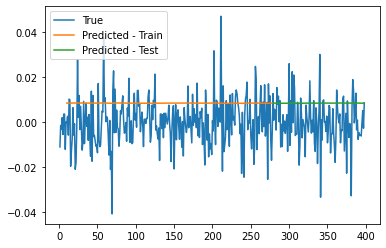

Epochs:  500  Iterations:  1503  Loss:  0.00012286085014541945
Epochs:  1000  Iterations:  3003  Loss:  0.0001089271512076569
Epochs:  1500  Iterations:  4503  Loss:  0.00010543093958403915
Epochs:  2000  Iterations:  6003  Loss:  0.0001159347957582213
Epochs:  2500  Iterations:  7503  Loss:  0.00010048701490935248
Epochs:  3000  Iterations:  9003  Loss:  9.6855820932736e-05
Epochs:  3500  Iterations:  10503  Loss:  8.67459627140003e-05
Epochs:  4000  Iterations:  12003  Loss:  6.894670029093201e-05
Epochs:  4500  Iterations:  13503  Loss:  8.438408137105095e-05
Epochs:  5000  Iterations:  15003  Loss:  4.842768066737335e-05
Epochs:  5500  Iterations:  16503  Loss:  8.171150269239054e-05
Epochs:  6000  Iterations:  18003  Loss:  7.228126499588446e-05
Epochs:  6500  Iterations:  19503  Loss:  9.535780191072263e-05
Epochs:  7000  Iterations:  21003  Loss:  4.04901050690872e-05
Epochs:  7500  Iterations:  22503  Loss:  3.1976354762264236e-05
Epochs:  8000  Iterations:  24003  Loss:  3.032

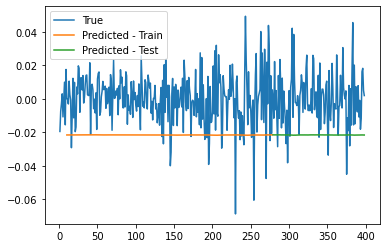

Epochs:  500  Iterations:  1503  Loss:  0.00035981521553670365
Epochs:  1000  Iterations:  3003  Loss:  0.000332949045211232
Epochs:  1500  Iterations:  4503  Loss:  0.0001645447628106922
Epochs:  2000  Iterations:  6003  Loss:  0.0001285842696840215
Epochs:  2500  Iterations:  7503  Loss:  0.00011552640118376682
Epochs:  3000  Iterations:  9003  Loss:  0.00011141226938586139
Epochs:  3500  Iterations:  10503  Loss:  6.685050023709967e-05
Epochs:  4000  Iterations:  12003  Loss:  5.2033896812038925e-05
Epochs:  4500  Iterations:  13503  Loss:  3.067318569568064e-05
Epochs:  5000  Iterations:  15003  Loss:  7.357353564430014e-05
Epochs:  5500  Iterations:  16503  Loss:  4.067056367299907e-05
Epochs:  6000  Iterations:  18003  Loss:  2.8970287985430332e-05
Epochs:  6500  Iterations:  19503  Loss:  9.971291213635898e-05
Epochs:  7000  Iterations:  21003  Loss:  1.0365258257631163e-05
Epochs:  7500  Iterations:  22503  Loss:  4.137487186047413e-06
Epochs:  8000  Iterations:  24003  Loss:  

OSError: [Errno 22] Invalid argument: './DARNN_20211128_run/y_pred_73.csv'

In [10]:
batchsize = 128
nhidden_encoder = 128
nhidden_decoder = 128
ntimestep = 10
lr = 0.001
epochs = 10000

# 폴더 없으면 생성
try:
    if not os.path.exists(file_name):
        os.makedirs(file_name)
except OSError:
    print ('Error: Creating directory. ' +  file_name)

y_preds = np.array([]) # numpy array로 해야 transpose 가능할것 같습니다.
for ticker_idx in range(len(tickers)):
    
    X = tra_data_X[ticker_idx]
    y = tra_data_Y[ticker_idx]

    # Initialize model
    print("==> Initialize DA-RNN_{} model ...".format(ticker_idx))
    globals()['model_{}'.format(ticker_idx)] = DA_rnn(
        X,
        y,
        ntimestep,
        nhidden_encoder,
        nhidden_decoder,
        batchsize,
        lr,
        epochs
    )

    model = globals()['model_{}'.format(ticker_idx)]

    # Train
    print("==> Start training ...")
    model.train()

    # Prediction
    y_pred = model.test()
    globals()['y_pred_{}'.format(ticker_idx)] = y_pred

    # y_pred_{ticker_idx} save to csv
    np.savetxt(file_name+'y_pred_{}.csv'.format(ticker_idx), y_pred, delimiter=',')

    # y_preds에 ticker_idx별 y_pred 저장하기
    if ticker_idx == 0 :
        y_preds = np.hstack((y_preds, y_pred))
    
    else :
        y_preds = np.vstack((y_preds, y_pred))


    fig1 = plt.figure()
    plt.semilogy(range(len(model.iter_losses)), model.iter_losses)
    plt.savefig(file_name+"iter_losses_{}_{}.png".format(tickers[ticker_idx],ticker_idx))
    plt.close(fig1)

    fig2 = plt.figure()
    plt.semilogy(range(len(model.epoch_losses)), model.epoch_losses)
    plt.savefig(file_name+"epoch_losses_{}_{}.png".format(tickers[ticker_idx],ticker_idx))
    plt.close(fig2)

    fig3 = plt.figure()
    plt.plot(y_pred, label='Predicted')
    plt.plot(model.y[model.train_timesteps:], label="True")
    plt.legend(loc='upper left')
    plt.savefig(file_name+"test_y_{}_{}.png".format(tickers[ticker_idx],ticker_idx))
    plt.close(fig3)
    print('Finished Training')

np.savetxt(file_name+'y_preds.csv', y_preds, delimiter=',')

In [ ]:
select_y_cum_return = [1]
# 시간대별로 선택된 ticker_idx들의 실제 y값 매치한후, 누적수익률 구함
for t in range(int(tensor_tra_data_Y[:,model.train_timesteps:,0].shape[1])):
    # t시점의 선택된 ticker_idx들
    indices = torch.Tensor(y_preds).topk(3,dim=0)[1][:,t]
    select_y_cum_return.append(select_y_cum_return[t] * (1 + tensor_tra_data_Y[:,model.train_timesteps:,0][indices, t].sum()/3))

# 위 시점에서 index의 cum_return_rate 구해보자
raw_data_index_path = './data/stocknet-dataset/price/raw/index'

fname = os.listdir(raw_data_index_path)[0]

df = pd.read_csv(os.path.join(raw_data_index_path,fname))
data = preprocess(df, windows)

learning_data = data[(data['Date'] >= tra_date) & (data['Date'] <= end_date)]['Date']
# tra_data_X_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)][COLUMNS_FEATURE]
tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['adjclose_lastadjclose_ratio']


index_cum_return = [1]
for t in range(int(tensor_tra_data_Y[:,model.train_timesteps:,0].shape[1])):
    index_cum_return.append(index_cum_return[t] * (1 + tra_data_Y_ticker.values[model.train_timesteps:][t]))

plt.plot(range(len(select_y_cum_return)), select_y_cum_return, label='portfolio')
plt.plot(range(len(index_cum_return)), index_cum_return, label='index')
plt.legend()
plt.savefig(file_name+"cum_return_rate_epochs{}.png".format(epochs))
plt.show()